In [1]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from scipy.stats import mode as scipymode



In [2]:
sns.set_style('darkgrid')

## Scraping tournament data from a particular webpage. 


Below will be a short script that will send a get request to the wiki page for the tournament event 'Tera'. Then using BeautifulSoup to scrape data from a table on the page containing the tournament results. These results are from a tournament for the game'Super Smash Bros. Ultimate' (SSBU). Some events schedule tournaments for every game in the series. Sometimes there are both singles and doubles tournaments hosted  at the same event (individual competitiors or duos). Tera was exclusively an SSBU event.


In [2]:
# url for the tournament page on the super smash bros wiki
url = 'https://www.ssbwiki.com/Tournament:Tera'
#sends a get request to the url
response = requests.get(url)

# parses HTML text using BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')


#
#Will use find method on soup object to locate desired information from the parsed html text.
#


#finds the span tag of the page with the attribute id for relevant tournament details
span = soup.find('span', id='Super_Smash_Bros._Ultimate_singles')
    
# span from before is the child of a heading <h3> tag
heading = span.find_parent('h3')

#Finds the first table tag with attribute class 'wikitable'
table = heading.find_next_sibling('table',class_='wikitable')


# initialise a list to store the row data
rows_data = []

#finds all table row tags <tr> inside the table object (children of the table tree)
rows = table.find_all('tr')[1:65]  # excludes header row with columns names

for row in rows:
    # obtain <td> tags which represent standard data cells in the table. 
    cells = row.find_all(['td'])
        
    # player placing in first cell of a row.  
    
    place = cells[0].get_text(strip=True) #use get_text to retrieve string representing the players tournament placing

    # second cell has player_tag and country of origin each in a different html anchor.
    # there are two anchor tags <a>, so assign them to 'cell_country_player' 
    cell_country_player = cells[1].find_all(['a']) 
                         
    # Ignores the anchors that represent a superscript in the cell text as they are not relevant data
    cell_country_player = [a for a in cell_country_player if not a.find_parent('sup')] 
    
    #extract country text from the first anchor
    country = cell_country_player[0].get('title') 
   
    # extract player text from the second anchor
    player = cell_country_player[-1].get_text(strip=True) #players name is always the final anchor. 
    
    #extract the character names into a list and remove the the text '(SSBU)' from their representative strings. 
    
    pattern = r'\s*\(SSBU\)'
    character_list = [char.get('title') for char in cells[2].find_all('a')]
    characters = [re.sub(pattern, '', char) for char in character_list] 
    
    # appends the data into the row_data list
    rows_data.append([place, country, player, characters])
    

# display row data to check values are correct.
for row_data in rows_data:
    print("Place:", row_data[0])
    print("Country:", row_data[1])
    print("Player:", row_data[2])
    print("Characters:", row_data[3])

Place: 1st
Country: France
Player: Glutonny
Characters: ['Wario']
Place: 2nd
Country: USA
Player: Tweek
Characters: ['Diddy Kong']
Place: 3rd
Country: Mexico
Player: Sparg0
Characters: ['Cloud']
Place: 4th
Country: USA
Player: Light
Characters: ['Fox']
Place: 5th
Country: UK
Player: Bloom4Eva
Characters: ['Bayonetta']
Place: 5th
Country: France
Player: Raflow
Characters: ['Palutena']
Place: 7th
Country: Sweden
Player: big chungus
Characters: ['Steve']
Place: 7th
Country: USA
Player: Zomba
Characters: ['R.O.B.']
Place: 9th
Country: Spain
Player: AndresFn
Characters: ['Terry', 'Ken']
Place: 9th
Country: Spain
Player: Sisqui
Characters: ['Samus', 'Dark Samus']
Place: 9th
Country: USA
Player: BassMage
Characters: ['Jigglypuff']
Place: 9th
Country: Germany
Player: Tarik
Characters: ['Greninja', 'Kazuya']
Place: 13th
Country: Japan
Player: Yoshidora
Characters: ['Yoshi']
Place: 13th
Country: France
Player: Leon
Characters: ['Lucina']
Place: 13th
Country: France
Player: crêpe salée
Characters

## Extracting event details and their individual webpage urls. 
There are normally two types of large scale tournament events 'majors' and 'supermajors'. 

From the ssbwiki: 

'A major is an exceptionally prestigious tournament that has a very high amount of entrants and a very high level of skill density among the entrants, with many of the game's top players and borderline top players in attendance. A supermajor is among the most prestigious tournaments of all, where the skill density is so high that they're an established level above majors, with them having most of the game's very best players in attendance and attracting players from across the world to compete.'

In this notebook from every MAJOR an SUPERMAJOR events starting from 2022 until today will be analysed. There is a table available on the wiki with information for every major and supermajor event per year for every year since the game was released. The names of each event on the table are hyperlinks to the tournaments specific page. Supermajors have their names' text emboldened. The hosting nation's flag is next to the name of every event on the table. We can extract the urls to each tournament event webpage, the names of each event and their locations and the dates over which they took place.

I'm creating a list of names of the SUPERMAJOR tournaments to filter out these tournaments in a future dataframe

In [3]:
url = 'https://www.ssbwiki.com/List_of_major_tournaments_(SSBU)'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

#instantiate empty lists for the urls, tournament details ,Supermajor tournament names. 
url_list = []
tournament_details = []
years = ['2022','2023','2024'] 
supermajor_tournaments = []

for year in years:
    span = soup.find('span', id= year)
    heading = span.find_parent('h2')
    table = heading.find_next_sibling('table',class_='wikitable')
    
    rows = table.find_all('tr')[1:]
    for row in rows:
        #extract cells
        cells = row.find_all(['td'])
          
    
        #extract tournament name, location and url
        
        name_loc_url = cells[0].find_all('a') #name/location/url inside the same cell. 
        tourney_loc = name_loc_url[0].get('title') #location in first anchor
        
        tourney_name = name_loc_url[1].get_text(strip=True) #name in second anchor
        
        #link (wiki path) is in href attribute of second anchor. 
        tourney_url =  name_loc_url[1].get('href') 

        if cells[0].find('b'): # supermajors appear in bold on the table
            supermajor_tournaments.append(tourney_name)
        
        #extract date of tournament from second cell
        tourney_date = cells[1].get_text(strip=True) + ' ' + year #days and month are given only so we need to add year. 
        
        #append tournament details and url to list
        tournament_details.append([tourney_loc, tourney_name, tourney_date])
        url_list.append(tourney_url) 
    

In [4]:

for i in range(len(url_list)): # check to see we have every piece of information as required
    print(tournament_details[i], url_list[i])

['USA', "Let's Make Big Moves 2022", 'January 7th-9th 2022'] /Tournament:Let%27s_Make_Big_Moves_2022
['Japan', 'Kagaribi 6', 'January 8th-9th 2022'] /Tournament:Kagaribi_6
['USA', 'Glitch - Infinite', 'February 18th-20th 2022'] /Tournament:Glitch_-_Infinite
['USA', 'Smash Ultimate Summit 4', 'March 3rd-6th 2022'] /Tournament:Smash_Ultimate_Summit_4
['USA', 'Collision 2022', 'March 12th-13th 2022'] /Tournament:Collision_2022
['Mexico', 'Delfino Maza RETA 2022', 'April 1st-3rd 2022'] /Tournament:Delfino_Maza_RETA_2022
['USA', 'GENESIS 8', 'April 15th-17th 2022'] /Tournament:GENESIS_8
['USA', 'Pound 2022', 'April 22nd-24th 2022'] /Tournament:Pound_2022
['USA', 'Low Tide City 2022', 'April 29th-May 1st 2022'] /Tournament:Low_Tide_City_2022
['Japan', 'Maesuma TOP 7', 'May 1st 2022'] /Tournament:Maesuma_TOP_7
['Japan', 'Kagaribi 7', 'May 4th-5th 2022'] /Tournament:Kagaribi_7
['USA', 'MomoCon 2022', 'May 27th-29th 2022'] /Tournament:MomoCon_2022
['Canada', 'Battle of BC 4', 'June 10th-12th 20

## Scraping all event desired results
Tournament results from each supermajor tournament from the start of 2022. We extract them in as before retrieving all data by iterating though the list of tournament urls. 

Key changes to script:
- Retrieving player name as the title of their specific page on the wiki (if one is available) to avoid confusion of shared player tags. If no page is available the link leads to a default page informing that there is no text available on the page.
- Player tag is taken as before if theres no official link to their page for that tournaments url (or if they dont have a page)
- Some players wiki pages have spans within the header tag dispalying their name and others don't. The code checks for both. 


In [5]:
ssbwiki_url = 'https://www.ssbwiki.com' #base_url for the wiki
#initialise a list that contains the full player and tournament data
full_data = []
s = requests.Session()
for i in range(len(url_list)): #loop through each url and run similar scrip to that above
    response =  s.get(ssbwiki_url+url_list[i])
    
    soup = BeautifulSoup(response.text, 'html.parser') #parse html as text from link
    
    #
    #Will use find method on soup object to locate desired information from the parsed html text.
    #
    
    #find span tag  with the ID attribute containing SSBU singles.
    if soup.find('span', id='Super_Smash_Bros._Ultimate_singles'): #some pages do not have this span (ssbu singles only tournaments)
        span = soup.find('span', id='Super_Smash_Bros._Ultimate_singles')
        
        # If span tag is found, navigate to the parent heading tag <h3> and then to next table
        heading = span.find_parent('h3')
        table = heading.find_next_sibling('table',class_='wikitable')
        
        rows = table.find_all('tr')[1:65]  # find all table row tags <tr> exlcuding header
        for row in rows:
            # extract cells from the row
            cells = row.find_all(['td'])
                
            # extract player placing data from cell
            place = cells[0].get_text(strip=True)
            
        
            #extract the player and nationality from the cell and assign them to separate variables 
            cell_country_player = cells[1].find_all(['a']) 
            cell_country_player = [a for a in cell_country_player if not a.find_parent('sup')]
            country = cell_country_player[0].get('title')
            
            #obtain url path for specific players page official or 'placeholder page'
            player_link  = cell_country_player[-1].get('href')
            
            
            #check if path contains this string. If so url redirects to default page with no information so we ignore these cases. 
            if '?action=edit&redlink' in player_link: 
                player = cell_country_player[-1].get_text(strip=True) 
            else:
                player_name_url = ssbwiki_url+player_link #baseurl plus the url path for player page
                
                player_name_response = s.get(player_name_url)
                
                second_soup = BeautifulSoup(player_name_response.text, 'html.parser')
                
                if second_soup.find('span', class_='mw-page-title-main'):#finds span tag with desired attribute class 
                    #get_text (player tag)from span tag 
                    player = (second_soup.find('span', class_='mw-page-title-main')).get_text(strip=True) 
                
                else:
                    #finds span tag with desired attribute class
                    heading_name =second_soup.find('h1',class_='firstHeading mw-first-heading')  
                    
                    
                    #these urls have no span class so "Smasher:" is the first part of the string return from the get_text method.
                    #used regex method to replace "Smasher:" with empty string
                    player = re.sub(r'^Smasher:','',heading_name.get_text(strip=True))

            #extract the characters into a list and remove the '(SSBU)'
            pattern = r'\s*\(SSBU\)'
            character_list = [char.get('title') for char in cells[2].find_all('a')]
            characters = [re.sub(pattern, '', char) for char in character_list]
            # append row data to the full_data list
            full_data.append([place, country, player, characters] + tournament_details[i])
    else:
        table = soup.find('table',class_='wikitable')
        rows = table.find_all('tr')[1:33]  # Exclude the header row
        for row in rows:
            # Extract cells from the row
            cells = row.find_all(['td'])
                
            # Extract player position data from cell
            place = cells[0].get_text(strip=True)
            
        
            #extract the player and nationality from the cell and assign them to separate variables 
            cell_country_player = cells[1].find_all(['a']) 
            cell_country_player = [a for a in cell_country_player if not a.find_parent('sup')]
            country = cell_country_player[0].get('title') 
            player_link  = cell_country_player[-1].get('href')
    
            if '?action=edit&redlink' in player_link:
                player = cell_country_player[-1].get_text(strip=True) 
            else:
                player_name_url = ssbwiki_url+player_link
                player_name_response = s.get(player_name_url)
                second_soup = BeautifulSoup(player_name_response.text, 'html.parser')
                if second_soup.find('span', class_='mw-page-title-main'):
                    player = (second_soup.find('span', class_='mw-page-title-main')).get_text (strip=True)
                else:
                    heading_name =second_soup.find('h1',class_='firstHeading mw-first-heading')
                    player = re.sub(r'^Smasher:','',heading_name.get_text(strip=True)) 
        
            #extract the characters into a list and remove the '(SSBU)'
            pattern = r'\s*\(SSBU\)'
            character_list = [char.get('title') for char in cells[2].find_all('a')]
            characters = [re.sub(pattern, '', char) for char in character_list]
            # append row data to full_data list
            full_data.append([place, country, player, characters] + tournament_details[i])
s.close()
# TAKES HALF AN HOUR TO RUN ON MY MACHINE. SO TRY IF PATIENT.

## Creating the DataFrame
A list of column names will be created and with these and the list "full_data" created above a dataframe with all our information can be created.

In [309]:
column_names = ['placing','nation','player','characters_played','tournament_country','tournament_name','date']

In [310]:
df = pd.DataFrame(full_data, columns = column_names)

## Let's get a quick understanding of the dataset:

In [276]:
variables = pd.DataFrame(columns = ['variable','No of unique Values','values'])

# expanding array values of characters_played into separate rows on a new dataframe
chars = df.explode('characters_played') 

for i, var in enumerate(df.drop(columns=['characters_played']).columns): # character_played is a list and unhashable
    variables.loc[i] = [var, df[var].nunique(), df[var].unique().tolist()]


variables.loc[6] = ['characters_played',chars['characters_played'].nunique(), chars['characters_played'].unique().tolist()]
variables

,variable,No of unique Values,values
0,placing,20,"[1st, 2nd, 3rd, 4th, 5th, 7th, 9th, 13th, 17th..."
1,nation,35,"[USA, Germany, Australia, Canada, Japan, Franc..."
2,player,1380,"[Quidd, Kola, MuteAce, Dabuz, Scend, Goblin, F..."
3,tournament_country,5,"[USA, Japan, Mexico, Canada, France]"
4,tournament_name,101,"[Let's Make Big Moves 2022, Kagaribi 6, Glitch..."
5,date,99,"[January 7th-9th 2022, January 8th-9th 2022, F..."
6,characters_played,96,"[Pokemon Trainer, Roy, Cloud, Peach, Rosalina ..."


### Data Dictionary


placing - object      -      The final position the player placed in the competition

nationality   -    object      -      Nationality of the player

player_tag    -    object       -     tagname of player

location     -     object       -     location of tournament

tournament_name-  object      -      Name of tournament event. 

date      -        object    -        Date the tournament took place.

characters_played - ARRAY of object  - The characters played by a specific player during the tournament. ##

#### Cleaning the data
- Date column is currently in text form and needs to be adjusted and then converted to datetime type. 
- The values for a players nationality are instead names of their home nationand need to be changed.
- Conversion of certain columns to more appropariate or less memory occupying datatypes. 

#### Details worth flagging:
- The total number of unique characters played is 96 however only 86 are available to pick in game.
- There should be fewer than 20 unique values for "placing".

---

#### Correcting number of unique characters played. 

A standardised full list of the characters names are required. These will be scraped from the official wiki page about the characters available in the game. A list of these names will be compared to the values in the dataset to locate outliers. 

The official wiki page with the character details is: https://www.ssbwiki.com/Super_Smash_Bros._Ultimate#Fighters

In [357]:
#scraping follows the same logic as before just scraping from a slightly different table. 

url = 'https://www.ssbwiki.com/Super_Smash_Bros._Ultimate#Fighters'

character_list = []

response = requests.get(url)

soup = BeautifulSoup(response.text,'html.parser')

table = soup.find('table',class_='wikitable')

rows = table.find_all('tr')
for row in rows:
    cells = row.find_all('td')
    
    pattern = r'\s*\(SSBU\)'
    for cell in cells:
        if cell.find('a'):
            character_anchor = cell.find('a')
            character = character_anchor.get('title')
            #apppend the list of characters to the list instantiated above.
            character_list.append(re.sub(pattern, '', character))
        else:
            continue


#create a list with the unique character values from the dataframe named "characters_in_df"
characters_in_df = df.explode('characters_played')['characters_played'].unique().tolist()

#creates set of values inside the 2 lists so that they can be compared.
set1 = set(characters_in_df)
set2 = set(character_list)

#finds values not in each set
values_not_in_list2 = list(set1.difference(set2))
values_not_in_list1 = list(set2.difference(set1))

#print values to identify outliers.
print( values_not_in_list2)
print(values_not_in_list1)


['PyraMythra']
['Pyra']


In this scraped list of characters the character Pyra/Mythra (two characters in one) has only come out as Pyra, the official entry is "Pyra & Mythra". 
For consistency and preference I will make the following replacements in the dataset:
- 'Pyra/Mythra' and 'Pyra Mythra' to 'PyraMythra'
- 'Pokemon Trainer' to 'Pokémon Trainer'
- 'Banjo', 'Banjo&Kazooie' to 'Banjo & Kazooie'
- 'Rosalina' to 'Rosalina & Luma'
- 'ROB','R.O.B' to 'R.O.B.'
- 'Bowser Jr' to 'Bowser Jr.'
- 'random' will be removed. When selecting 'random' in the character select screen a character is chosen at random for the plater.
- nan value(s) will be identified to check if their are other sources to obtain the correct data. 

In [85]:
#assigns the row with a nan value in characters_played to "nan_value"
nan_value = df.explode('characters_played').characters_played.isna() 
df.explode('characters_played')[nan_value]

,placing,nation,player,characters_played,tournament_country,tournament_name,date
3337,33rd,Japan,Kazari,NaN,Japan,Seibugeki 14,July 1st 2023


There is no available information on which character was played by Kazari at this tournament and it is the only major tournament they have participated in. As such the row will be removed from the dataset. 


In [311]:
df = df.drop(df.index[3337])

#### Placing values

In [12]:
df.placing.unique().tolist() #Creates a list of the current placing values in the dataset

['1st',
 '2nd',
 '3rd',
 '4th',
 '5th',
 '7th',
 '9th',
 '13th',
 '17th',
 '25th',
 '33rd',
 '49th',
 '25th*',
 '5th*',
 '23rd',
 '29th',
 '49th*',
 '13th*',
 '9th*',
 '10th']

Official wiki states that placing values with an asterisk indicate that a player was disqualified subqequently exiting the tournament at that position. This detail is unecessary for the analysis, asterisks will be removed.

---

#### Which player picked 'Random'? 
The wikitable displays a character icon on cells representing the characters picked by a player. 'Random' selects a random character from the roster. The symbol for random used was the random symbol from the previous game in the series which is why it is accompanied by '(SSB4)'. Let's see which characters this player used from picking random.

In [13]:
#Locates row where the value is random
df.explode('characters_played')[df.explode('characters_played')['characters_played']=='Random (SSB4)'] 

,placing,nationality,player,characters_played,tournament_country,tournament_name,date
4056,49th,USA,Stroder Ame,Random (SSB4),USA,Rise 'N Grind 2023,October 13th-15th 2023


In [14]:
#Identify the names of the characters plated at the tournament by this player.
df.explode('characters_played').loc[4056]

,placing,nationality,player,characters_played,tournament_country,tournament_name,date
4056,49th,USA,Stroder Ame,Random (SSB4),USA,Rise 'N Grind 2023,October 13th-15th 2023
4056,49th,USA,Stroder Ame,Sora,USA,Rise 'N Grind 2023,October 13th-15th 2023
4056,49th,USA,Stroder Ame,Donkey Kong,USA,Rise 'N Grind 2023,October 13th-15th 2023
4056,49th,USA,Stroder Ame,Diddy Kong,USA,Rise 'N Grind 2023,October 13th-15th 2023
4056,49th,USA,Stroder Ame,Kazuya,USA,Rise 'N Grind 2023,October 13th-15th 2023
4056,49th,USA,Stroder Ame,Richter,USA,Rise 'N Grind 2023,October 13th-15th 2023


The 'Random' value will be removed leaving the name of the actual characters played.


#### Identifying the unique country/nation values
Identifying the unique nation values to find the correpsonding nationality to include in a future tweak function to  ensure column 'nationality' actually has nationality values.

In [97]:
df.nation.unique()

array(['USA', 'Germany', 'Australia', 'Canada', 'Japan', 'France', 'UK',
       'Mexico', 'Costa Rica', 'Spain', 'Finland', 'Puerto Rico',
       'Dominican Republic', 'Brazil', 'Honduras', 'Saudi Arabia',
       'Netherlands', 'Switzerland', 'Luxembourg', 'Norway', 'Austria',
       'Israel', 'Sweden', 'Guatemala', 'Chile', 'Colombia', 'Ecuador',
       'Ireland', 'Belgium', 'United States', 'United Kingdom', 'Italy',
       'Peru', 'Hong Kong', 'Philippines'], dtype=object)

Both the UK and USA appear twice as nations under "UK"/"United Kingdom" and "USA"/"United States". UK AND USA will be replaced.  

In [312]:
df = df.assign(is_supermajor = lambda df_ :df_.tournament_name.isin(supermajor_tournaments))

#### Visualising the distribution of tournaments/players in each region.

<Figure size 900x350 with 0 Axes>

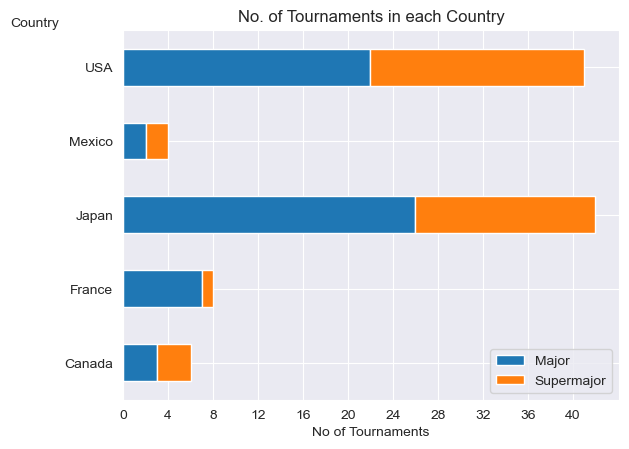

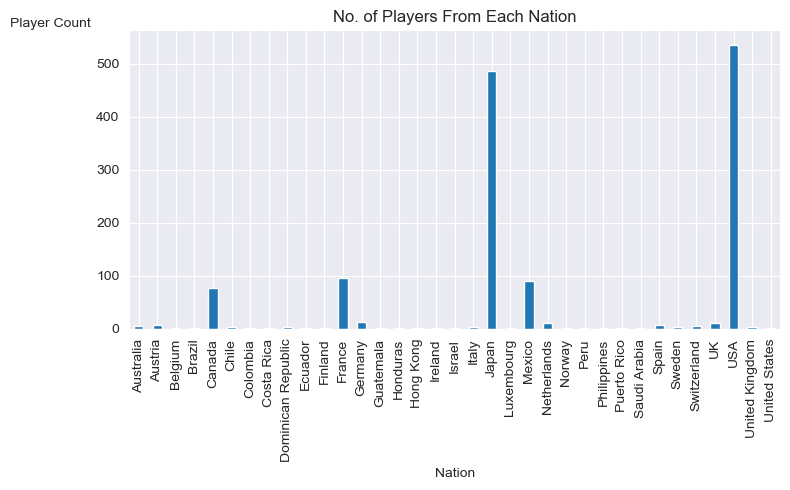

In [313]:
plt.figure(figsize=(9,3.5))
#groups data by tournament_country, returns the number of unique tournaments in each country and plots them revealing dist. of super/major tourmanents.
data = df.groupby(['tournament_country','is_supermajor',], observed=False).tournament_name.nunique().unstack()
data.plot.barh(stacked=True)
#.plot.barh(stacked=True)
plt.xlabel('No of Tournaments')
plt.ylabel('Country',rotation=0,loc='top')
plt.xticks(range(0,44,4))
plt.legend(labels=['Major','Supermajor'])
plt.title('No. of Tournaments in each Country')





plt.figure(figsize=(8,5))
#groups data by player_region and plots the number unique players in each one.
df.groupby(['nation'], observed=True)['player'].nunique().plot.bar()
#plt.xticks(range(0,721,50))
plt.ylabel('Player Count', rotation = 0,loc='top')
plt.xlabel('Nation',rotation=0)
plt.title('No. of Players From Each Nation')

plt.tight_layout();


Nation values will be replaced with the corresponding naionalities which will be further grouped into the following regions: Australia, South America, North America,Japan, Europe and Asia.

Japan will exist as a separate region from Asia due to the relatively large number of players from there. 

---

#### What goes inside the tweak function:
Reducing the memory usage of the dataframe, adding some new columns and ordering any categories.

The tweak function will:
- add an ordering to the placing values. 
- replace instances of the names of the characters_played being wrong and remove the 'random' value
- change the date values from being strings in the form of "Month day-day Year" to 2 values of the start and end date in the form of Month -Day - Year which can then be changed into datetime with pandas.
- nation of origin will be replaced with nationality.
- all nations replaced with their region (continent) or in the case of Australia and Japan, remain the same.
- player_name, tournament_name and placing will be converted to the categorical datatype.
- Tournament countries will be grouped into 3 regions: North America, Europe and Japan.
- reset the index.


In [314]:
def tweak_func(df):

    #instatiate a list to inform the order of the placing values
    placement_order = ['1st', '2nd', '3rd','4th', '5th', '7th', '9th','10th', '13th' ,'17th','23rd','25th','29th','33rd','49th']

    def character_name_replacement(characters_played):
        #use list comprehension to take values in the characters_played cell in row and check they arent the random value
        characters_played = [char for char in characters_played if char != 'Random (SSB4)']
        #use the list to create a pandas series item which can utilise the replace method.
        series = pd.Series(characters_played)
        #replace instances of non standardised spellings to standardised ones. 
        series.replace({'Pyra/Mythra': 'PyraMythra','Pyra Mythra':'PyraMythra','R.O.B':'R.O.B.','ROB':'R.O.B.', 'Pokemon Trainer':'Pokémon Trainer',
                          'Banjo': 'Banjo & Kazooie','Banjo&Kazooie':'Banjo & Kazooie','Rosalina':'Rosalina & Luma','Bowser Jr':'Bowser Jr.'}, inplace=True)
        #returns the series as a list
        return series.tolist()
        
    
    def parse_date(date_str):
        
        '''Takes a date string such as "January 12th-20th 2022" 
        and using regex expression and match method, matches the month,
        day and year. These are split into groups using groups method. 
        The individual groups are indexed to corresponding variables.
        The variables are then formatted into a string and converted to
        pandas Timestamp dtype. This is interpretable 
        by pandas to convert it into a datetime dtype. Function returns a tuple
        of Timestamp variables in the form of month day year'''
        
        month_day_year = re.match(r'(\w+)\s+(\d+)(?:st|nd|rd|th)?(?:-?(\D+)?(?:\s+)?(\d+)?(?:st|nd|rd|th)?)\s+(\d+)', date_str)
        if month_day_year:
            groups = month_day_year.groups()
            month =  groups[0]
            start_day = groups[1]
            end_month = groups[2] if groups[2] else groups[0] # use start month if tournament doesnt persist over 2 months
            end_day = groups[3] if groups[3] else groups[1] # use start date if tournament is one day event
            year = groups[4]
            return pd.Timestamp(f'{month} {start_day} {year}'), pd.Timestamp(f'{end_month} {end_day} {year}')
        else:
            return None, None

    return  (df                                                    #replaces nation name with nationality name
            .assign(nationality= lambda df_:df_.nation.replace({'USA': 'American', 'Germany': 'German', 'Australia': 'Australian','Canada': 'Canadian', 
                                                                     'Japan': 'Japanese', 'France': 'French','UK': 'British', 'Mexico': 'Mexican', 
                                                                     'Costa Rica': 'Costa Rican','Spain': 'Spanish', 'Finland': 'Finnish', 'Puerto Rico': 'Puerto Rican',
                                                                     'Dominican Republic': 'Dominican', 'Brazil': 'Brazilian', 'Honduras': 'Honduran',
                                                                     'Saudi Arabia': 'Saudi Arabian', 'Netherlands': 'Dutch', 'Switzerland': 'Swiss',
                                                                     'Luxembourg': 'Luxembourgish', 'Norway': 'Norwegian', 'Austria': 'Austrian','Israel': 'Israeli', 
                                                                     'Sweden': 'Swedish', 'Guatemala': 'Guatemalan','Chile': 'Chilean', 'Colombia': 'Colombian', 
                                                                     'Ecuador': 'Ecuadorian','Ireland': 'Irish', 'Belgium': 'Belgian', 'United States': 'American',
                                                                     'United Kingdom': 'British', 'Italy': 'Italian', 'Peru': 'Peruvian','Hong Kong': 'Hong Kong Chinese',
                                                                    'Philippines':'Filipino'}).astype('category'),
                #new column called player region is assigned values based on nationality columns where nationality is replaced with region value
                    player_region=lambda df_: df_.nationality.replace({'American': 'North America', 'German': 'Europe', 'Australian': 'Australia',
                                                                    'Canadian': 'North America', 'French': 'Europe', 'British': 'Europe',
                                                                    'Mexican': 'North America', 'Costa Rican': 'North America', 'Spanish': 'Europe',
                                                                    'Finnish': 'Europe', 'Puerto Rican': 'North America', 'Dominican': 'North America',
                                                                    'Brazilian': 'South America', 'Honduran': 'North America', 'Saudi Arabian': 'Asia',
                                                                    'Dutch': 'Europe', 'Swiss': 'Europe', 'Luxembourgish': 'Europe', 'Norwegian': 'Europe',
                                                                    'Austrian': 'Europe', 'Israeli': 'Asia', 'Swedish': 'Europe', 'Guatemalan': 'North America',
                                                                    'Chilean': 'South America', 'Colombian': 'South America', 'Ecuadorian': 'South America',
                                                                     'Irish': 'Europe', 'Belgian': 'Europe', 'Italian': 'Europe', 'Peruvian': 'South America',
                                                                       'Hong Kong Chinese': 'Asia','Japanese':'Japan','Filipino':'Asia'}).astype('category'),
                    
                    #replaces misspelled character names and removed random value
                    characters_played = lambda df_:df_.characters_played.apply(character_name_replacement),
                    
                    #converts player_tag and tournament_country to a categorical data type
                    player = lambda df_:df_.player.astype('category'),
                    tournament_country = lambda df_:df_.tournament_country.astype('category'),
                    
                    #replaces tournament country value with the region/continent they belong to and assigns data to new categorical column
                    tournament_region = lambda df_:df_.tournament_country.replace({'USA': 'North America', 'Canada': 'North America',
                                                                                  'Mexico': 'North America', 'France' :'Europe'}).astype('category'),
                    
                    #converts tournament_name to a categorical datatype.
                    tournament_name = lambda df_:df_.tournament_name.astype('category'),
                    
                    #replaces unwanted placing values and sets the column to an ordered categorical datatype.
                    placing=lambda df_: df_.placing.replace({'25th*':'25th','13th*':'13th','49th*':'49th','5th*':'5th','9th*':'9th'}).astype('category').cat.reorder_categories(placement_order, ordered=True),
                    
                    #convert the date strings from the date column into two new columns end date and start date with datetime datatypes.
                    start_Date=lambda df_: pd.to_datetime(df_['date'].apply(lambda x: parse_date(x)[0]).dt.date),
                    end_Date=lambda df_: pd.to_datetime(df_['date'].apply(lambda x: parse_date(x)[1]).dt.date)
                    
                   )
           #removes the now unneccessary date column from the dataframe
               .drop(columns=['date','nation'])
               .reset_index(drop=True))

df = tweak_func(df)

#### Let's take a look at the updated DataFrame's values:

In [293]:

#instatiate new dataframe'variables' with three columns headings.
variables = pd.DataFrame(columns = ['variable','No of unique Values','values'])

# expanding array values of characters_played into separate rows on a new dataframe
chars = df.explode('characters_played') 

#loop through each column in the original dataframe except characters_played.
for i, var in enumerate(df.drop(columns=['characters_played']).columns): # characters_played is a list and unhashable
    
    #assign the variable name, number of unique vales and list of unique values to rows in the dataframe
    variables.loc[i] = [var, df[var].nunique(), df[var].unique().tolist()]

#sets a final row with values of the characters_player from the 'chars' dataframe from above
variables.loc[11] = ['characters_played',chars['characters_played'].nunique(), chars['characters_played'].unique().tolist()]
variables

,variable,No of unique Values,values
0,placing,15,"[1st, 2nd, 3rd, 4th, 5th, 7th, 9th, 13th, 17th..."
1,nation,35,"[USA, Germany, Australia, Canada, Japan, Franc..."
2,player,1379,"[Quidd, Kola, MuteAce, Dabuz, Scend, Goblin, F..."
3,tournament_country,5,"[USA, Japan, Mexico, Canada, France]"
4,tournament_name,101,"[Let's Make Big Moves 2022, Kagaribi 6, Glitch..."
5,is_supermajor,2,"[False, True]"
6,nationality,33,"[American, German, Australian, Canadian, Japan..."
7,player_region,6,"[North America, Europe, Australia, Japan, Sout..."
8,tournament_region,3,"[North America, Japan, Europe]"
9,start_Date,98,"[2022-01-07 00:00:00, 2022-01-08 00:00:00, 202..."


The data now looks as expected.

In [294]:
df.sample(8) #sample of 16 rows from the dataset

,placing,nation,player,characters_played,tournament_country,tournament_name,is_supermajor,nationality,player_region,tournament_region,start_Date,end_Date
428,9th,USA,SHADIC,[Corrin],USA,Low Tide City 2022,False,American,North America,North America,2022-04-29,2022-05-01
5294,33rd,Japan,Uraomote,[Wario],Japan,Sumabato SP 46,False,Japanese,Japan,Japan,2024-04-14,2024-04-14
3910,33rd,Japan,Shirayuki,[Inkling],Japan,DELTA 5,True,Japanese,Japan,Japan,2023-09-23,2023-09-24
4743,13th,Japan,Komugiko,[Mega Man],Japan,UltCore Second,False,Japanese,Japan,Japan,2024-01-27,2024-01-27
5671,17th,Japan,Rizeasu,"[Marth, Robin, Ike]",Japan,Sumabato SP 48,False,Japanese,Japan,Japan,2024-06-15,2024-06-15
339,33rd,USA,Anathema,[R.O.B.],USA,GENESIS 8,True,American,North America,North America,2022-04-15,2022-04-17
2392,13th,USA,Wrath,[Sonic],USA,LVL UP EXPO 2023,False,American,North America,North America,2023-02-17,2023-02-19
1631,33rd,USA,Rob.,[Snake],USA,The Big House 10,False,American,North America,North America,2022-10-07,2022-10-09


In [296]:
df.isna().sum()

placing               0
nation                0
player                0
characters_played     0
tournament_country    0
tournament_name       0
is_supermajor         0
nationality           0
player_region         0
tournament_region     0
start_Date            0
end_Date              0
dtype: int64

To potentially assist us in future I will create more dataframes filtering for specific data. 

In [297]:

# Creates 3 lists containing the placing for top 8, top16 and top32 tournament placings respectively
top8_placings = ['1st','2nd','3rd','4th','5th','7th']
top16_placings = top8_placings + ['9th','10th','13th']
top32_placings = top16_placings + ['17th','23rd','25th','29th'] 

#instantiate dataframes containing just players in the top 8, 16 and 32 of tournaments respectively.
df_top8 = df[df['placing'].isin(top8_placings)]
df_top16 = df[df['placing'].isin(top16_placings)]
df_top32 = df[df['placing'].isin(top32_placings)]

#The same as above but for supermajor tournaments. 
df_supermajors = df[df['tournament_name'].isin(supermajor_tournaments)] #All data excluxively for supermajor tournaments.
df_supermajors_top8 = df_supermajors[df_supermajors['placing'].isin(top8_placings)]
df_supermajors_top16 = df_supermajors[df_supermajors['placing'].isin(top16_placings)]
df_supermajors_top32 = df_supermajors[df_supermajors['placing'].isin(top32_placings)]

### Visualising the distributions of players and nationalities

- Players from each region.
- Nationalities from each region.


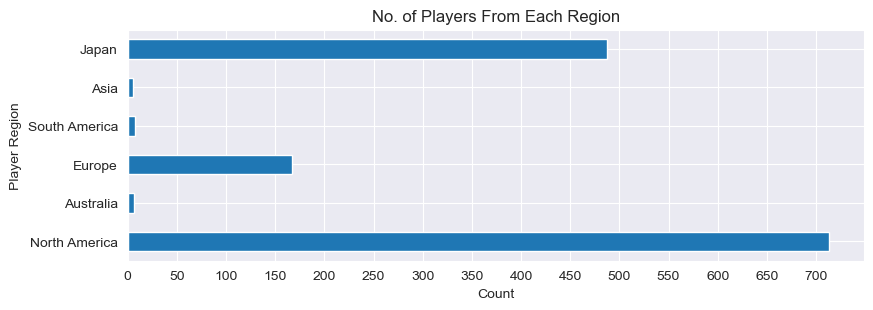

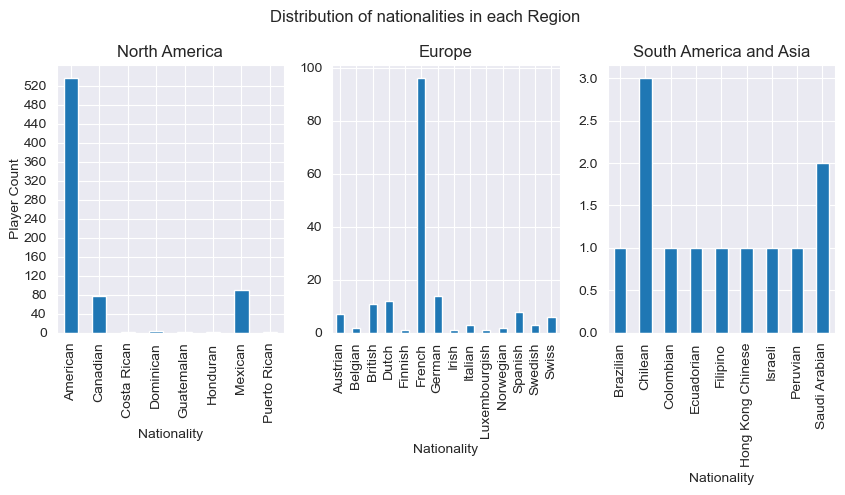

In [116]:

plt.figure(figsize=(9.5,3))
#groups data by player_region and plots the number unique players in each one.
df.groupby(['player_region'], observed=True)['player'].nunique().plot.barh()
plt.xticks(range(0,721,50))
plt.ylabel('Player Region')
plt.xlabel('Count')
plt.title('No. of Players From Each Region')

#loops through lists of regions, grouping by nationality and plotting the number of unique players in each one
fig, ax = plt.subplots(1,3, figsize=(8.5,5))
regions = ['["North America"]', '["Europe"]','["South America","Asia"]']
for i, x in enumerate(regions):
    (
    df.query(f'player_region.isin({x})')
    .groupby(['nationality'],observed=True)['player']
    .nunique()
    .plot.bar(ax=ax[i])
    )
    
#The following sets axis ticks, labels and titles. 
ax[0].set_ylabel('Player Count')
ax[0].yaxis.set_label_coords(-0.10, 0.5)  # Adjust the x-coordinate to shift the label to the left
ax[1].set_ylabel('', rotation = 0)
ax[0].set_yticks(range(0,541,40))
ax[0].set_xlabel('Nationality')
ax[1].set_xlabel('Nationality')
ax[2].set_xlabel('Nationality')
ax[0].set_title('North America')
ax[1].set_title('Europe')
ax[2].set_title('South America and Asia')
ax[0].yaxis.set_label_coords(-0.15, 0.5)
plt.suptitle('Distribution of nationalities in each Region')
plt.tight_layout();


## Questions We Can Answer?

With this data it is possible begin to answer a few interesting questions concerning the state of high level metagame and the competitive scene and how it has changed since the start of 2022. 

- Which characters are most commonly picked by players? 
- What does the player diversity look like at tournaments? 
- How does the metagame differ by region. Are the most popular characters played in Japan the same as the characters played in the Europe and the Americas? 
- Which players have dominated the competitive scene since 2023? Has there been any shift?
- If you were a player looking to observe quality play with a particular character, which players games would you 
watch? 
---

#### Distribution of players' region of origins for every tournament

What is the regional distribution of players for SUPERMAJOR tournaments in North America, Europe and Japan. 

I have chosen to combine North America and Europe as only one supermajor has taken place in Europe - "Tera". 

We can visualise the distribution of nationalities per tournament in each territory. By filtering the data to each region and then plotting a stacked horizontal bar chart with the player count next to each tournament with each different stack representing a different Region. 

There are four plots in each row, each has the same distribution rules per tournament however each focuses on a different tournament bracket.


I have decided to split the two sets of graphs into supermajor tournaments (first set directly below) and major tournaments( the following code cell output). Supermajors tend to have a more diverse distribution of players in the top64 or above from the definition given by the wiki. 

I have coloured the regions Asia and Australia category grey as they collectively represent very few players.

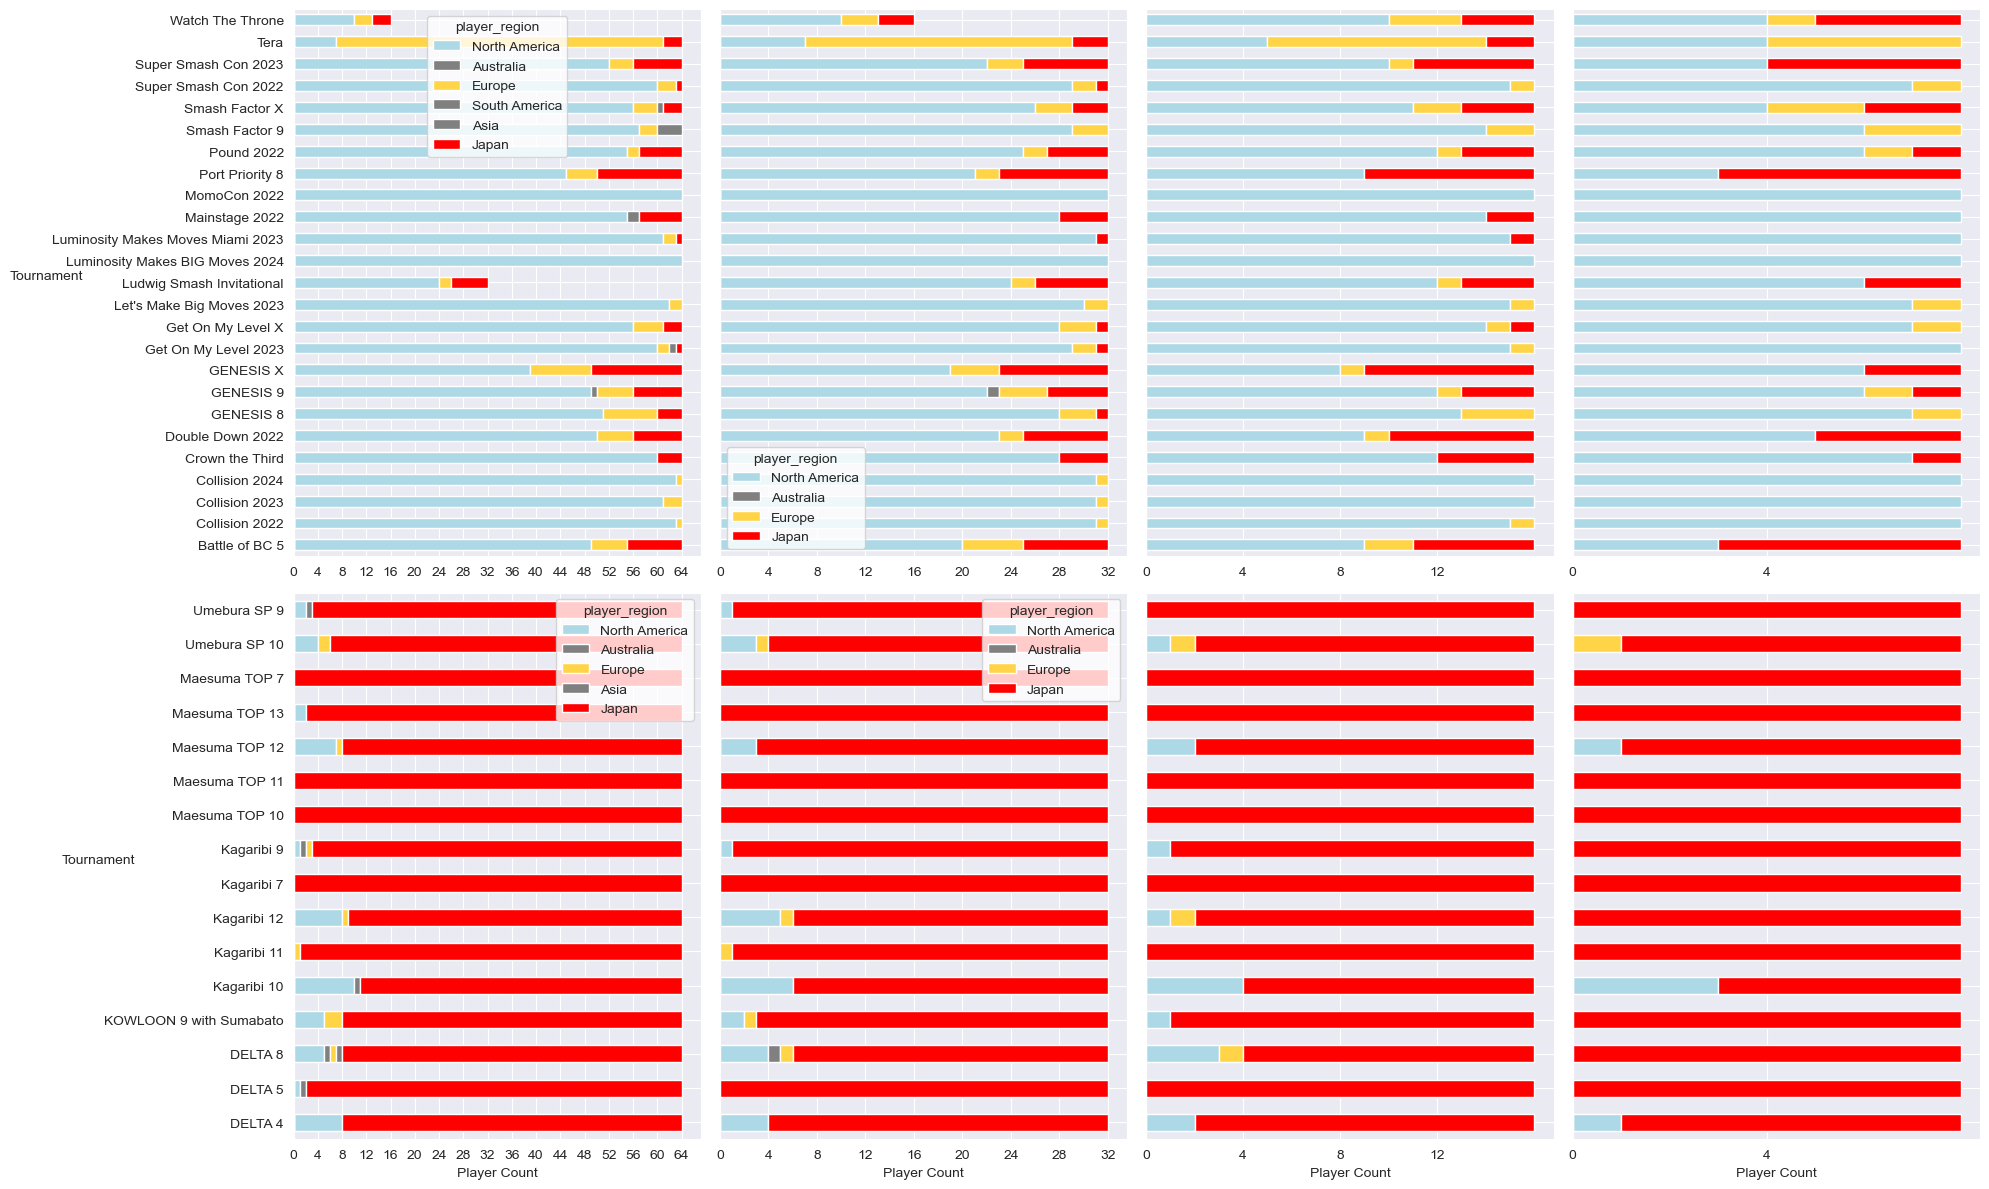

In [18]:
fig, ax = plt.subplots(2, 4, figsize=(20,12)) #instantiate subplots object and the total size of the figure. 
sns.set_style('whitegrid')

#instantiate a list of tuplpes containing relevant dataframe, desired x_tick limits, boolean for legend and plot title
dataframes_xticks = [(df_supermajors, 65, True, 'Top64'), (df_supermajors_top32, 33, True, 'Top32'), (df_supermajors_top16, 16, False, 'Top16'), (df_supermajors_top8, 8, False, 'Top8')]

#maps values of tournament regions to desired bar colour that will appear on the graphs.
color_map = {'North America':'lightblue' , 'Japan': 'red', 'Europe':'#ffd447'}

#loops through list of tuples to plot desired graphs
for i, (dataframe, num_tick, bool, placings) in enumerate(dataframes_xticks):
    
    #Filters dataframe for tournaments held in particular regions 
    data = dataframe.query('tournament_region == "North America" | tournament_region == "Europe"') 
    
    #Groups by name of tournament and player region, retrieving the total count of the former and unstacking the data
    stacked_data = data.groupby(['tournament_name', 'player_region'], observed=True).size().unstack()
    
    #plots the data on a horzintal bar chart.
    stacked_data.plot.barh(stacked=True, ax=ax[0,i], legend = bool, color = [color_map.get(col, 'gray') for col in stacked_data.columns])
    
    #sets axis labels,xticks and yticks
    ax[0,i].set_ylabel('', rotation=0)
    ax[0,i].set_yticklabels([])
    ax[0,0].set_ylabel('Tournament', rotation=0)
    ax[0,0].set_yticks(range(len(stacked_data.index)))
    ax[0,0].set_yticklabels(stacked_data.index)
   
    ax[0,i].set_xticks(range(0, num_tick, 4))

for i, (dataframe, num_tick, bool, placings) in enumerate(dataframes_xticks):
    data = dataframe.query('tournament_region == "Japan"')
    stacked_data = data.groupby(['tournament_name', 'player_region'], observed=True).size().unstack()
    stacked_data.plot.barh(stacked=True, ax=ax[1,i], legend = bool, color = [color_map.get(col, 'gray') for col in stacked_data.columns])
    ax[1,i].set_ylabel('', rotation=0)
    ax[1,i].set_yticklabels([])
    ax[1,0].set_yticks(range(len(stacked_data.index)))
    ax[1,0].set_yticklabels(stacked_data.index)
    ax[1,0].set_ylabel('Tournament', rotation=0)
    ax[1,i].set_xlabel('Player Count')
    ax[1,i].set_xticks(range(0, num_tick, 4))


plt.tight_layout();



### North American/ European Supermajor Tournament(s):
- NA had greater diversity in players from different regions, with multiple tournaments with Japanese and European players attendance.
- Tera was held in France and so it is expected that a majority of players in attendance would be European.
- Some tournaments only had sixteen players in attendance. Some quick research shows that these were special invitational tournaments with a select number of players. However this does not mean it is not useful as it can still help our insights into the metagame at high level play. 
- Japan has strong representation abroad. With Japanese players often competing in the top 8 brackets for a many of North American tournaments. 

### Japanese tournaments:
- While there are many tournaments with American, European and other Asian nation based players in the top 64 bracket, it seems that only in a few tournaments does a foregin player progress to the top 8 bracket. Where only one tournament had 3 players progress. 

---
Most players who enter competitions abroad tend to be very skilled. Often invited and sponsored. It is why they progress to the top8 bracket as frequently as they do.
It is apparent that NA based players are less successful when playing abroad compared to Japanese players.

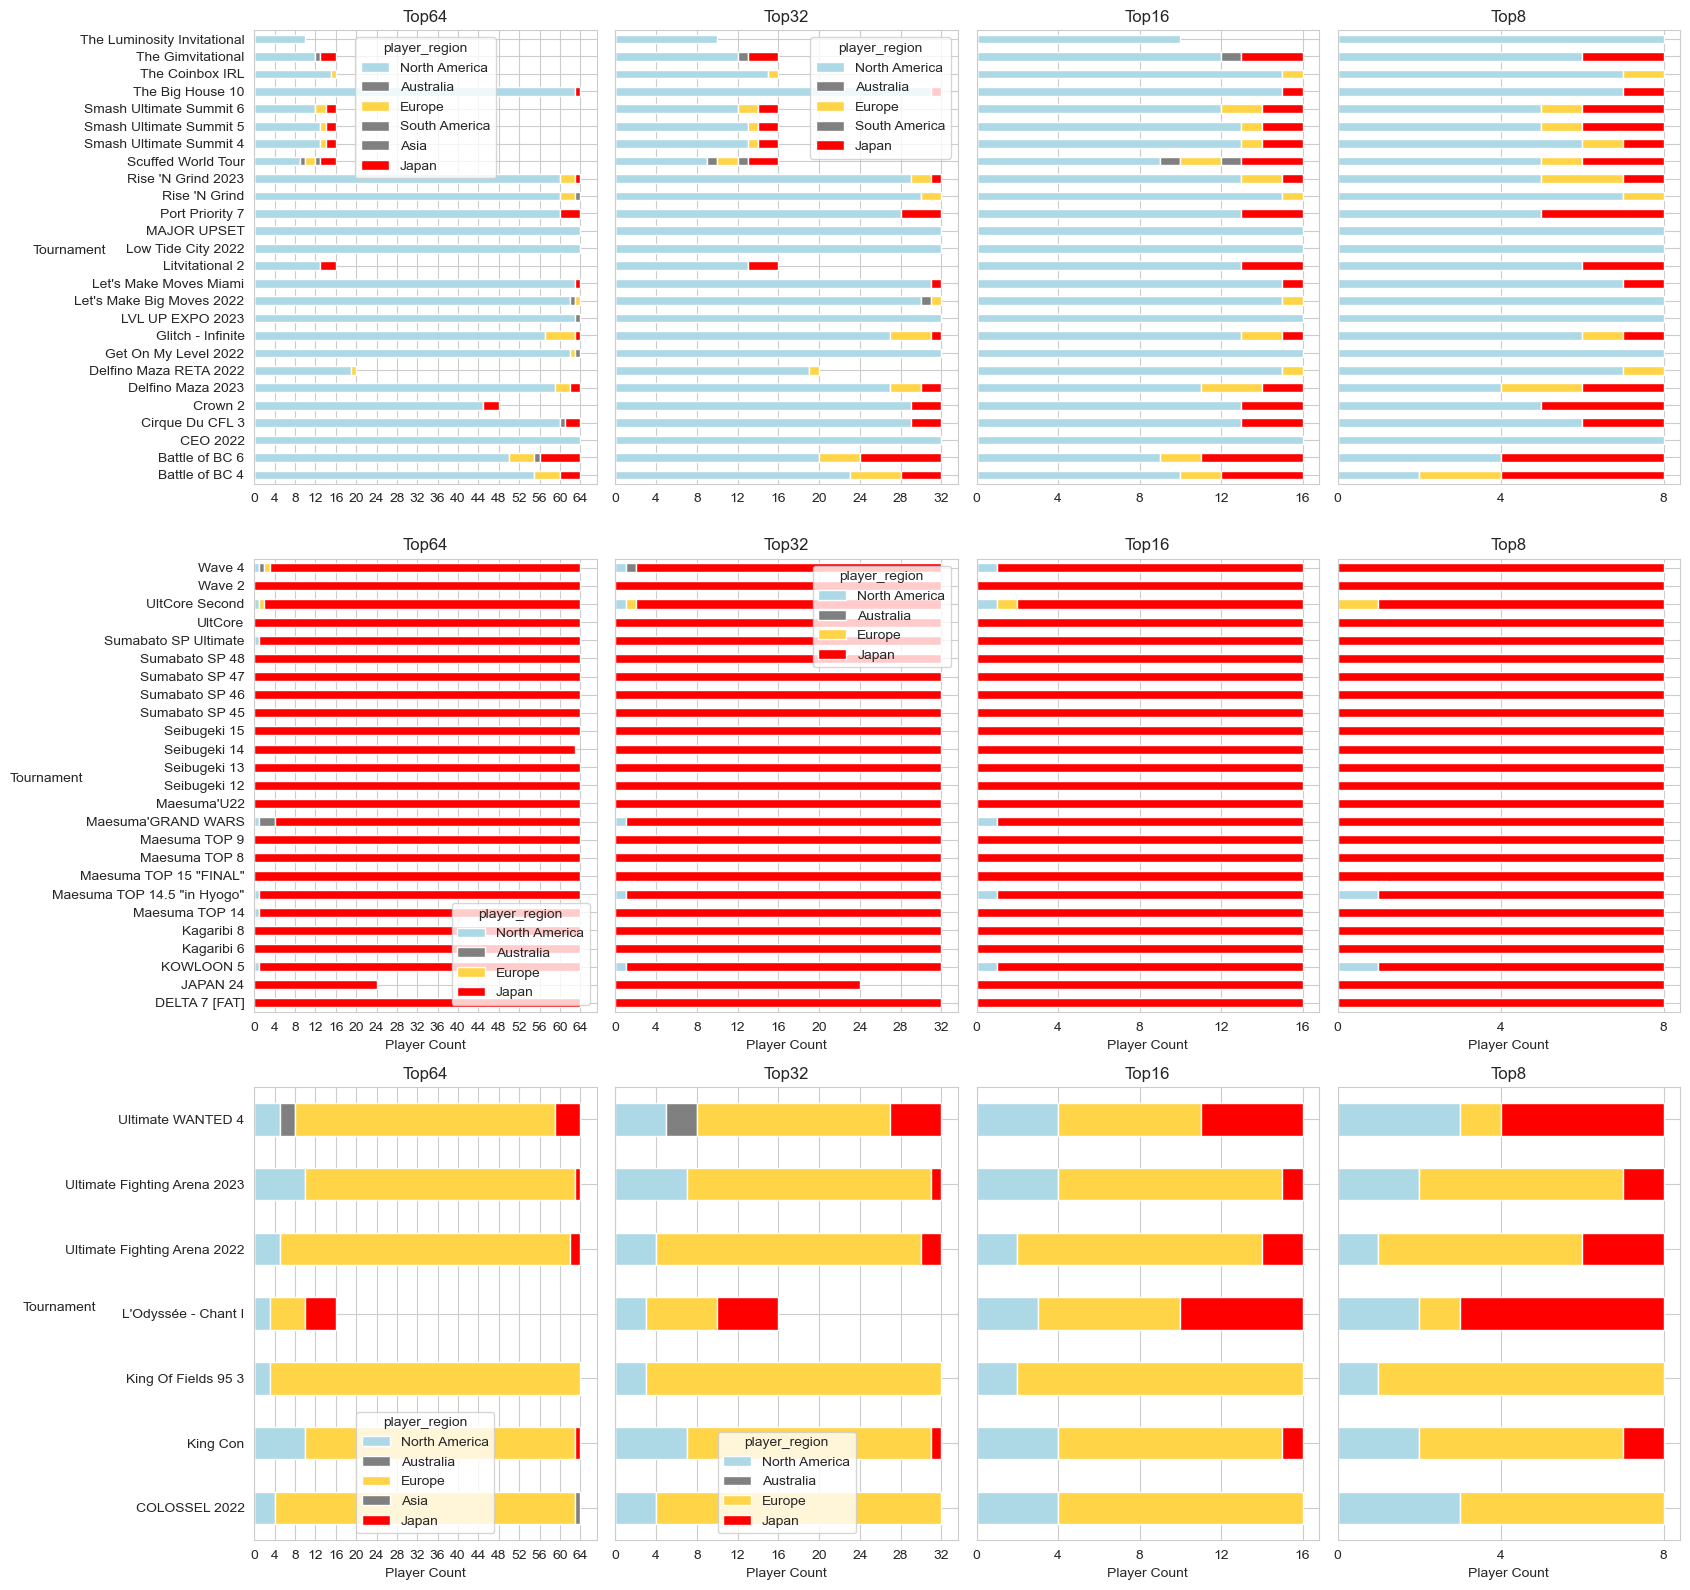

In [19]:
fig, ax = plt.subplots(3, 4, figsize=(17,16))
sns.set_style('whitegrid')
dataframes_xticks = [(df[~df['tournament_name'].isin(supermajor_tournaments)], 65, True, 'Top64'),
                     (df_top32[~df_top32['tournament_name'].isin(supermajor_tournaments)], 33, True, 'Top32'), 
                     (df_top16[~df_top16['tournament_name'].isin(supermajor_tournaments)], 17, False, 'Top16'), 
                     (df_top8[~df_top8['tournament_name'].isin(supermajor_tournaments)], 9, False, 'Top8')]
color_map = {'North America':'lightblue' , 'Japan': 'red', 'Europe':'#ffd447'}

for i, (dataframe, num_tick, bool, placings) in enumerate(dataframes_xticks):
    data = dataframe.query('tournament_region == "North America"')
    stacked_data = data.groupby(['tournament_name', 'player_region'], observed=True).size().unstack()
    stacked_data.plot.barh(stacked=True, ax=ax[0,i], legend = bool, color = [color_map.get(col, 'gray') for col in stacked_data.columns])
  
    ax[0,i].set_title(placings)
    ax[0,i].set_ylabel('', rotation=0)
    ax[0,i].set_yticklabels([])
    ax[0,0].set_ylabel('Tournament', rotation=0)
    ax[0,0].set_yticks(range(len(stacked_data.index)))
    ax[0,0].set_yticklabels(stacked_data.index)

    ax[0,i].set_xticks(range(0, num_tick, 4))

for i, (dataframe, num_tick, bool, placings) in enumerate(dataframes_xticks):
    data = dataframe.query('tournament_region == "Japan"')
    stacked_data = data.groupby(['tournament_name', 'player_region'], observed=True).size().unstack()
    stacked_data.plot.barh(stacked=True, ax=ax[1,i], legend = bool, color = [color_map.get(col, 'gray') for col in stacked_data.columns])
    
    ax[1,i].set_title(placings)
    ax[1,i].set_ylabel('', rotation=0)
    ax[1,i].set_yticklabels([])
    ax[1,0].set_yticks(range(len(stacked_data.index)))
    ax[1,0].set_yticklabels(stacked_data.index)
    ax[1,0].set_ylabel('Tournament', rotation=0)
    ax[1,i].set_xlabel('Player Count')
    ax[1,i].set_xticks(range(0, num_tick, 4))

for i, (dataframe, num_tick, bool, placings) in enumerate(dataframes_xticks):
    data = dataframe.query('tournament_region == "Europe"')
    stacked_data = data.groupby(['tournament_name', 'player_region'], observed=True).size().unstack()
    stacked_data.plot.barh(stacked=True, ax=ax[2,i], legend = bool, color = [color_map.get(col, 'gray') for col in stacked_data.columns])
    
    ax[2,i].set_title(placings)
    ax[2,i].set_ylabel('', rotation=0)
    ax[2,i].set_yticklabels([])
    ax[2,0].set_yticks(range(len(stacked_data.index)))
    ax[2,0].set_yticklabels(stacked_data.index)
    ax[2,0].set_ylabel('Tournament', rotation=0)
    ax[2,i].set_xlabel('Player Count')
    ax[2,i].set_xticks(range(0, num_tick, 4))
plt.tight_layout();

### A look at regular Major tournaments:

Based on the wiki definition the key difference between a Major and Supermajor tournament is the density of highly skilled players in attendance. Often the players participating attend the event from across the globe.

Invitational tournaments are special case. Super/Major tournaments have a large number of entrants and invitationals by nature do not. However only highgly skilled players are invited and often there is a great (proportionally) prize pool available and often recieve great viewership numbers. As such they would be considered Major tournaments.

### North America:
- Many invitationals.
- Follows the description of majors from the wiki. Tournaments have fewer players from different regions in the top64 bracket.

### Japan:
-Japanese majors are mainly populated by Japanese players by the top 64 bracket. With only 3 majors on the list where a foreign player progressed to the top8 bracket.
### Europe:
- Similar player distributions to North America except European player and American player distriution is reversed
- At least one North American players progress to the Top 8 bracket 100% of the time.

  
### Overall:
- NA and Japan host the most tournaments and notably it is players from these regions that progress furthest into the touraments when playing abroad. There are no instances where more than 2 European players progressed to the top8 bracket of a tournament. 

---
For the sake of curiosity who are the Australian and Asian and South American players are and how many tournaments they participated in?


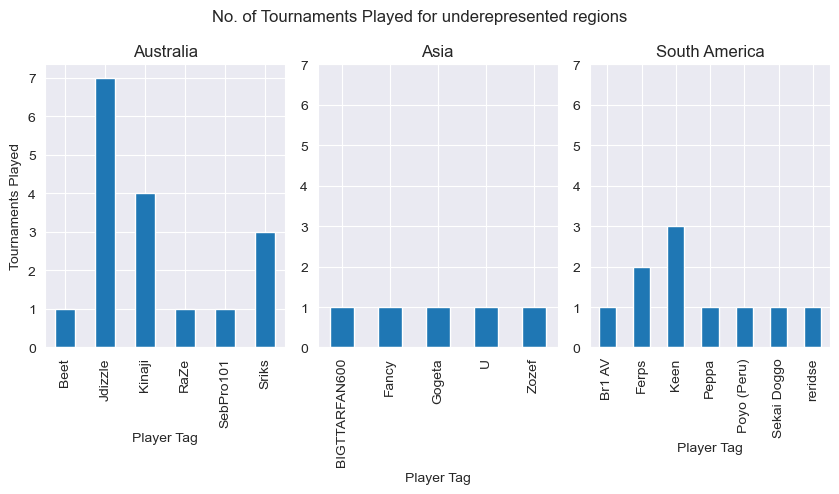

In [187]:
fig, ax = plt.subplots(1,3, figsize=(8.5,5))
regions = ['["Australia"]', '["Asia"]','["South America"]']
for i, x in enumerate(regions):
    (
    df.query(f'player_region.isin({x})')
    .groupby(['player'],observed=True)['tournament_name']
    .nunique()
    .plot.bar(ax=ax[i])
    )
    
#The following sets axis ticks, labels and titles. 
ax[0].set_ylabel('Tournaments Played')
 # Adjust the x-coordinate to shift the label to the left
ax[1].set_ylabel('', rotation = 0)

ax[0].set_xlabel('Player Tag')
ax[1].set_xlabel('Player Tag')
ax[2].set_xlabel('Player Tag')
ax[0].set_title('Australia')
ax[1].set_title('Asia')
ax[2].set_title('South America')
ax[0].set_yticks(range(0,8,1))
ax[1].set_yticks(range(0,8,1))
ax[2].set_yticks(range(0,8,1))
#ax[0].yaxis.set_label_coords(-0.15, 0.5)
plt.suptitle('No. of Tournaments Played for underepresented regions')
plt.tight_layout();

## Most popular characters by region

Regional differences in the 'metagame' are inevitable. 
One of the greatest choice players make in game is what character they will use. Some characters have advantages that may compliment their playstyle while others may have particular advantages against another character. Naturally in competitive play, individuals will choose characters that they believe will grant them the greatest chance of victory. 

On an individual level playstyles will differ and on a group level there will be indentifiable trends. Strategies and counter strategies will vary from group to group and from region to region. Let's check which characters are most popular in each region by counting the unique player who picked them comparing the trends with the overall global result.

The first graph shows the top 25% most popular characters across the globe. Subsequent graphs display the same for the regions Europe, North America and Japan. Characters that feature in both a regional chart and the global chart are given gold coloured bars otherwise will be red highlighitng characters that are more exclusively popular in a given region.

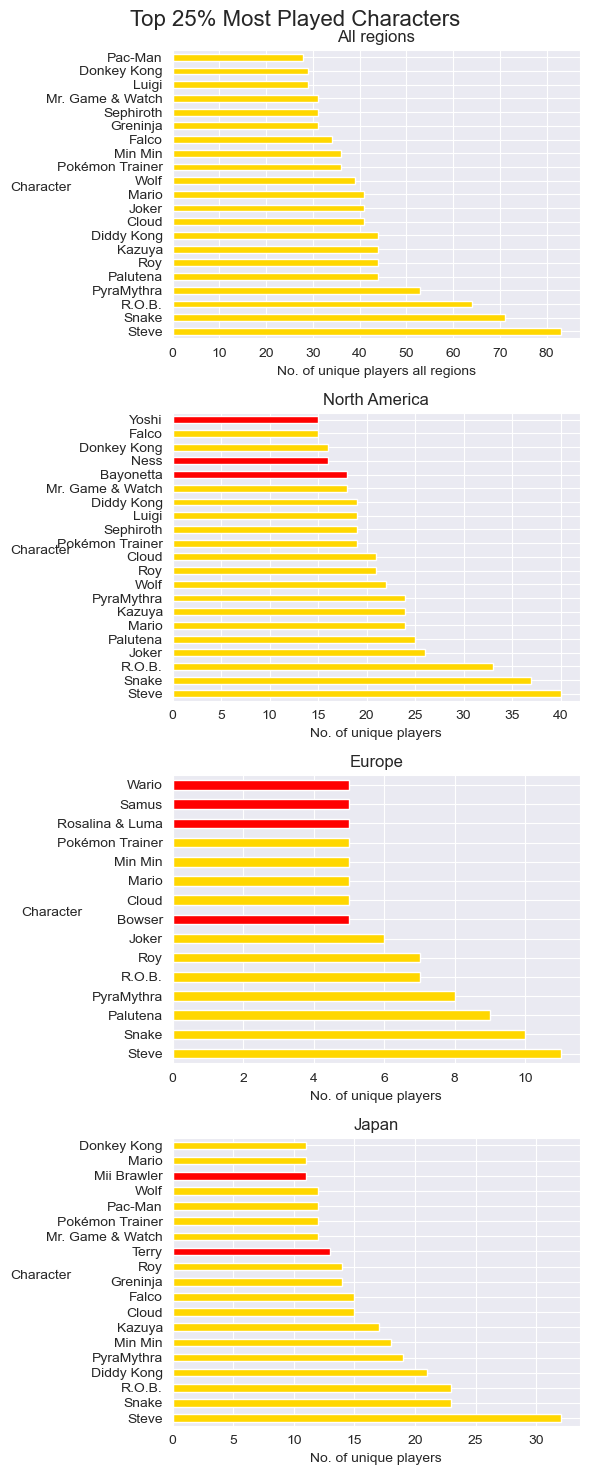

In [128]:
fig, ax = plt.subplots(4, 1, figsize=(6, 15))
#generate a list of tuples with region name and colour to be used in the bar charts.
regions = [('North America','red'), ('Europe','red'), ('Japan','red')]

#list of plot titles
titles = ['North America','Europe','Japan']


# The same logic that is applied above aplies below but this time consdiering every region at once.     
top_char_picks = (df.explode('characters_played').groupby(['characters_played'])['player'].nunique())

(
top_char_picks
    .pipe(lambda x: x[x>top_char_picks.quantile(0.75)])
    .sort_values(ascending=False)
    .plot.barh(ax=ax[0], color='gold')
)
ax[0].set_title('All regions')
ax[0].set_ylabel('Character', rotation=0)
ax[0].set_xlabel('No. of unique players all regions')
plt.suptitle('Top 25% Most Played Characters', fontsize=16)

overall_popular_chars = top_char_picks.pipe(lambda x: x[x>top_char_picks.quantile(0.75)]).sort_values(ascending=False).index.tolist()


#loops through region and colour tuples from 'regions' list
for i, (region,col) in enumerate(regions):
    
    #grouping data by characters_played and, retrieving the number of unique players for each and obtaining the 0.75 quantile value
    top_char_picks = (df.query(f'player_region == "{region}"').explode('characters_played')
                      .groupby(['characters_played'])['player'].nunique())
    
    #bar plotting the values, 
    (
        top_char_picks
        .pipe(lambda x: x[x>top_char_picks.quantile(0.75)]) #filters values above the top quartile value
        .sort_values(ascending=False) #sorts the values in ascending order.
        .plot.barh(ax=ax[i+1], 
                   color=['gold' if player in overall_popular_chars else col for player in top_char_picks.pipe(lambda x: x[x>top_char_picks.quantile(0.75)]).sort_values(ascending=False).index.tolist()]) #plots values
    )
    ax[i+1].set_title(titles[i])
    ax[i+1].set_ylabel('Character', rotation=0)
    ax[i+1].set_xlabel('No. of unique players')

    



plt.tight_layout()

- Occupying part of the 4 of the top 5 slots in each region are Steve, Snake, R.O.B and Pyra and Mythra. Its evident that at the top level these characters are considered to offer the best advantage or at the very least fun to play. We can get a better understanding by taking a look at the results associated with characters and their popularity.

- The near homogenous nature of the graphs can tell us that there isnt a significant difference in what characters are popular between regions. Some may rank higher or lower in popularity region depending but many of the same characters are popular through out. 
---


#### In the three years since the game received its final update has there been any change in the popularity of the most used characters?

The final update was the last instance of characters in the game being rebalanced. At this point the game is in its final state, over time this should in theory mean that players will slowly discover the best characters, and playstyles without worrying that anything will be changed in an update. 

Lets get a list of characters played the most overall. Aggregating the number of unique players per character for tournaments within 2 month windows from the start of 2022 and displaying the changes over time. The values will be noramlised by dividing each by the number of tournaments that occur in each 2 month window.

In [214]:
date_tourney = df.set_index('start_Date')[['tournament_name']]
nan_row = pd.DataFrame(index = [pd.Timestamp('2022-01-01')],columns=[name for name in date_player_char_tourney_.columns])
x = (  
        pd.concat([nan_row['player'], date_tourney.tournament_name])
        )

date_tourney_count = x.resample('2M',origin=pd.Timestamp('2022-01-01')).nunique()


In [208]:

#top_char_picks is assigned top 10th percentile value of the number unique players across all characters
top_char_picks = (df.explode('characters_played').groupby(['characters_played'])['player'].nunique().quantile(0.90))

#Use top_char_picks to create a list of the top ten percent most popular characters. 
character_list = (
                  df.explode('characters_played')
                    .groupby(['characters_played'])['player']
                    .nunique()
                    .pipe(lambda x: x[x>=top_char_picks]) # filters number of picks that are above the top 10th percentile value
                    .sort_values(ascending=False)
                    .index
                    .tolist()
                 )

#set a start date to resample from in the dataset
first_date_2022 = pd.Timestamp('2022-01-01').date

#instatiate a dataframe that has all the characters played values exploded with the date as the index
date_player_char_tourney_ = df.explode('characters_played').set_index('start_Date')[['player','characters_played','tournament_name']]


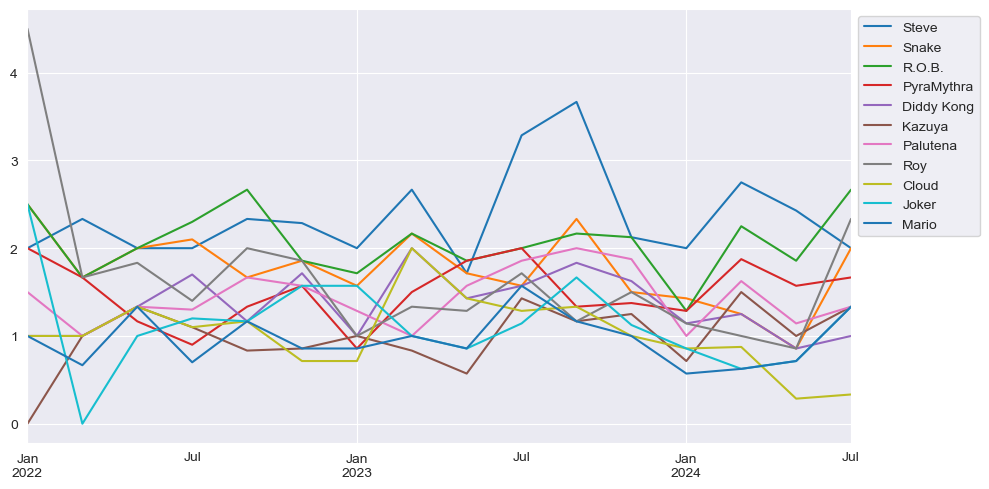

In [213]:
fig,ax = plt.subplots(figsize=(10,5))

#Create an empty dataframe called top_decile_char_df
top_decile_char_df = pd.DataFrame() 

#create a nan row dataframe containing one index value of 1st January 2022. Columns are the different characters from "characters_played"
nan_row = pd.DataFrame(index = [pd.Timestamp('2022-01-01')],columns=[name for name in date_player_char_tourney_.columns])

#loops through every character in character_list above.
for char in character_list:

    # x assigned a dataframe with first row being nan_row and date_player_char_tourney from above. 
    
    x = (  
        pd.concat([nan_row['player'], date_player_char_tourney_.query(f'characters_played == "{char}"')['player']])
        )
    
    #resamples by summing number of unique players for characters in character_list for every 2 month period starting 1st January 2022
    top_decile_char_df[char] = x.resample('2M',origin=pd.Timestamp('2022-01-01')).nunique() 
                                 

top_decile_char_df = (top_decile_char_df.apply(lambda row: row / date_tourney_count.loc[row.name], axis=1))
top_decile_char_df.plot.line(ax=ax)# Plot the resampled data to check how the popularity of the characters has changed over time. 
ax.legend(bbox_to_anchor=(1,1))
plt.tight_layout()

We can see that it has largely remained consistent. Steve's popularity had a notable surge in the summer of 2023 in comparison to the other characters. At this point in the games life. It is likely most players have settled in to their character of choice and are not that likely to consider a change.


####  Do players usually pick 1 or more characters in tournmaments?

One limit ot the dataset is that we don't know hhe percentage shares of usage that each player has with their picked characters. We can only know that a player picked characters X and Y in a tournament meaning:
- we  have no way of knowing that they picked character Y only in one game before switching back to X for the remainder of the tournament. Furthermore we don't know the success rate with the characters they choose in a tournament.
- there can be some ambigiuity when characters are ranked according to tournament results. It is possible for example for a player to lose games in a tournament with one character and win the rest with another and in some cases winning the tournament overall. However both character choices correspond to a win in the dataset.

However, the norm is that players pick one character which becomes their main, occasionally with 1 or 2 secondaries. Let's take a look at how common it is for players to pick more than one character. This way we can see how often or how likely it is to be the case that a players choices of characters are likely to create a large amount of confusion in the analysis.


  


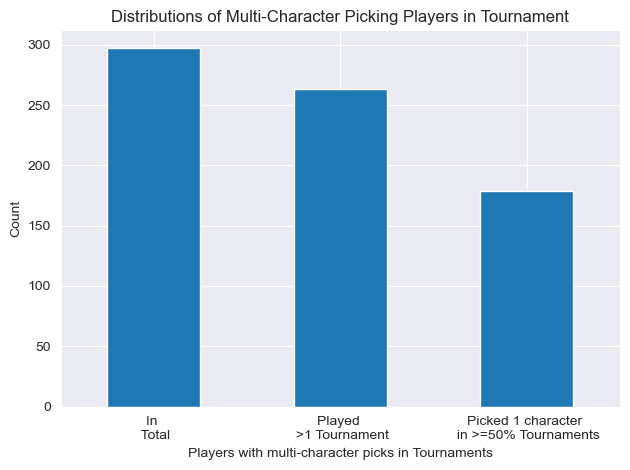

In [179]:
#create a list of the players who have picked more than one character in a tournament
plyrs_2_chars = (
                df.explode('characters_played')
                  .groupby(['player','tournament_name'],observed=True)['characters_played']
                  .count()
                  .pipe(lambda x: x[x>1])
                  .unstack()
                  .index
                  .tolist()
            )


#assigns variable a list of players who have appeared more than one tournament in the data.
plyrs_2_or_more_tourneys = (
                                df.groupby('player',observed=True)['tournament_name']
                                  .count()
                                  .pipe(lambda x: x[x>=2])
                                  .index
                                  .tolist()
                            )

#retrive players who picked more than  2 characters and also participated in more than 1 tournament. 
plyrs_gt2_tourneys_gt2_chars = (
                                df.explode('characters_played')
                                  .query('player.isin(@plyrs_2_or_more_tourneys)')
                                  .groupby('player',observed=True)['characters_played']
                                  .nunique()
                                  .pipe(lambda x: x[x>1])
                                  .index.tolist()

                                ) 
#retrieves no. of  tournaments players in 'plyrs_gt2_tourneys_gt2_chars' attended (at least progressed/qualified) to the top 64.
no_of_tourney_appearances    = (
                                  df
                                    .query('player.isin(@plyrs_gt2_tourneys_gt2_chars)')
                                    .groupby(['player'],observed=True)['tournament_name']
                                    .nunique()

                                )
#retrieve the number of tournaments played for each player in prievous list where they picked 1 character. 
num_tourneys_played_lt2_chars = (
                                df
                                    .query('player.isin(@plyrs_gt2_tourneys_gt2_chars)')
                                    .explode('characters_played')
                                    .groupby(['player','tournament_name'],observed=True)['characters_played']
                                    .count()
                                    .lt(2)
                                    .groupby('player',observed=True).sum()
                                    
                                 )
#assigns a dataframe containing the percentage of tournaments each player picked 1 character. Filters for those with >=50%
result = (num_tourneys_played_lt2_chars/no_of_tourney_appearances).mul(100).pipe(lambda x: x[x>=50])

#Create datafame with newly made data so it can be plotted
multiple_char_df = pd.DataFrame([{'Players with multi-character picks in Tournaments':'In \n Total','Quantity':len(plyrs_2_chars)},
                                 {'Players with multi-character picks in Tournaments':'Played \n >1 Tournament','Quantity':len(plyrs_gt2_tourneys_gt2_chars)},
                                 {'Players with multi-character picks in Tournaments':'Picked 1 character \n in >=50% Tournaments','Quantity':len(result)}])

multiple_char_df.plot.bar(x='Players with multi-character picks in Tournaments'
                          ,y='Quantity',ylabel='Count', rot=0,legend=False,
                          yticks=range(0,350,50), title='Distributions of Multi-Character Picking Players in Tournament')

plt.tight_layout()

Out of 1379 players, just under 300 have picked more than once character in a tournament. Of this fraction a large majority have played in more than 1 Top 64 Bracket. A majority of this fraction picked just 1 character most of the time. 
There a much fewer instances of players choosing 2 or more characters in a tournament. So we can assume that there won't be too much ambiguity in the analysis of character specific performance. 

It takes great levels of effort and a long time to fully learn the intricacies of just one character, therefore most players prefer to master just with some instances of players having a few pocket secondaries. All coming from the mindset that developing mastery over few characters versus fragmenting ones efforts between many could hinder tournament performance. The data lines up with this sentiment. 

---

#### Adding a new column to our dataframes.
I'm going to bin the placings into distinct groups Top 3: 2nd 3rd. Top 8: 4th 5th 7th, top 16: 9th and 13th. top 32 : 17th and 25th. 1st place, the highest achievement at a tournament will remain standalone.
This can help us answer some more questions about the popularity of characters.

In [315]:

#assign a new column in the dataframe that categorises the placings into groups. 1st, Top3,8,16,32 and 64
df = df.assign(
    placing_groups = lambda df: df.placing.replace({'2nd':'Top3','3rd':'Top3','4th':'Top8' ,'5th':'Top8', '7th':'Top8',
                                                   '9th':'Top16', '10th':'Top16', '13th':'Top16','17th': 'Top32',
                                                    '23rd': 'Top32','25th': 'Top32','29th': 'Top32',
                                                   '33rd':'Top64','49th':'Top64'})
)

### Is the popularity of a character linked to the frequency that character performs well in tournaments?
To check if theres any correlation between the two we can plot the popularity of each character against the number of times that character has appeared in the Top8 bracket of a tournament. Invitationals are included. 

                        no_unique_players  no_of_top8_appearances
no_unique_players                1.000000                0.702297
no_of_top8_appearances           0.702297                1.000000


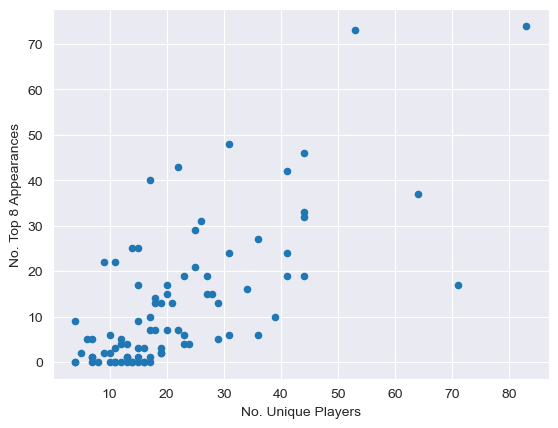

In [299]:
#series that compares each character in the dataset with the number of unique players who picked them.
uniq_players_per_char = (df 
    .explode('characters_played')
    .groupby(['characters_played'])['player']
    .nunique()
    
)
#Compares characters with the number of times a player has advanced to the top8 playing as them. 
chars_top8 = (
    df.explode('characters_played')
    .query('placing_groups.isin(["1st","Top3","Top8"])')
    .characters_played
    .value_counts()
                )


character_pop = pd.concat([uniq_players_per_char,chars_top8],keys = ['no_unique_players','no_of_top8_appearances'],axis=1)
character_pop.fillna(0).plot.scatter(y='no_of_top8_appearances',x='no_unique_players',
                                    xlabel='No. Unique Players',ylabel='No. Top 8 Appearances')
print(character_pop.fillna(0).corr())

There is a moderate positive correlation.

There a few reasons this could be:
- Community influence - The better players set an example for the rest of the scene influencing players to choose the same character they do.
- The dataset explores  the top 64 brackets (or smaller) instead of the whole tournament. It's possible that these characters have a larger sample size in this bracket compared to the whole tournament.


An interesting data point is Snake, despite being the 2nd most popular character he appears in less than 20 Top8s. Players might simply like the moveset Snake has, they may feel more comfortable playing as him or perhaps they see some advantage that Snake has against other characters that hasn't yet been fully realised yet.



---

 



# Tournament staples?

- Which characters are picked most by winning players?
- Which players have the most number of tournament wins?
- What share of the wins for certain charactera are the top winning players responsible for?

### What is the total number of wins for tournament winning players?

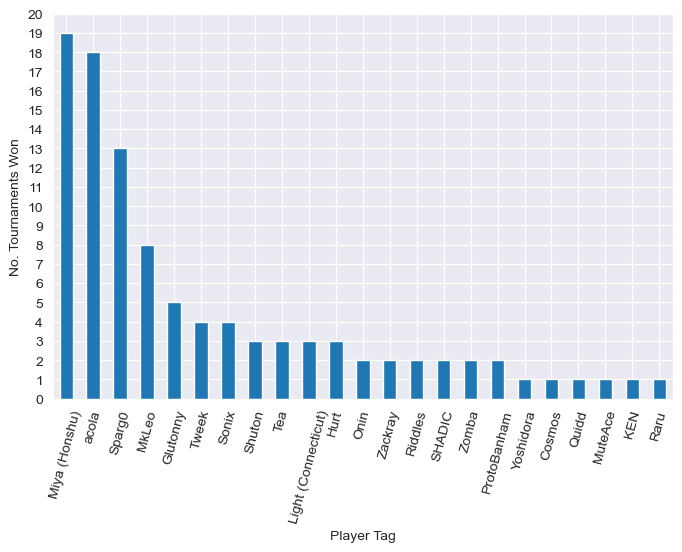

In [300]:
#Plots the number of tournaments that a player has won considering all players that have won at least a single tournament. 

fig, ax = plt.subplots(figsize=(8,5))
(
    df.query('placing == "1st"')
      .groupby(['player'], observed=True)['placing']
      .agg(['count'])  
      .sort_values(by='count', ascending = False)
      .plot.bar(rot = 75, ax=ax,legend=False)
)

ax.set_yticks(range(0,21,1))
ax.set_ylabel('No. Tournaments Won')
ax.set_xlabel('Player Tag');


### Number of tournament wins by character.


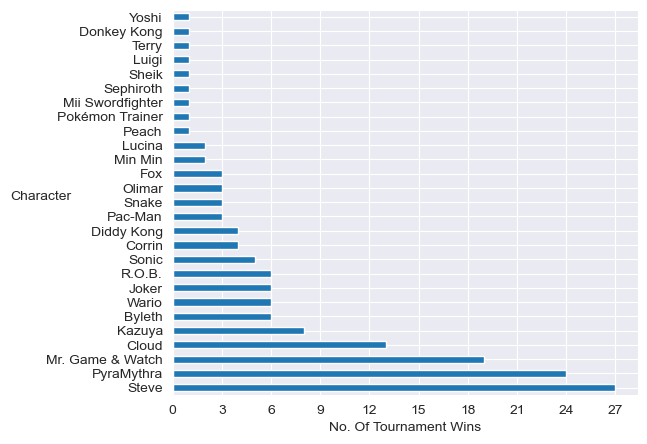

In [301]:
#Plots the number of times a character has been picked by the tournament winning player. 

fig, ax = plt.subplots(figsize=(6,5))
(
    df.explode('characters_played')
      .query('placing == "1st"')
      .groupby(['characters_played'], observed=True)['placing']
      .count()  # returns a column with a list of tournaments and a list with the number of tournaments. 
      .sort_values( ascending = False)
      .plot.barh()
)

ax.set_xticks(range(0,28,3))
ax.set_ylabel('Character', rotation=0 )
ax.set_xlabel('No. Of Tournament Wins');

# Characters used by the top 5 players

Miya, acola, Sparg0, MkLeo and Gluttony are the top 5 most successful players by total tournament wins. Let's identify the share of wins they have for their chosen characters.


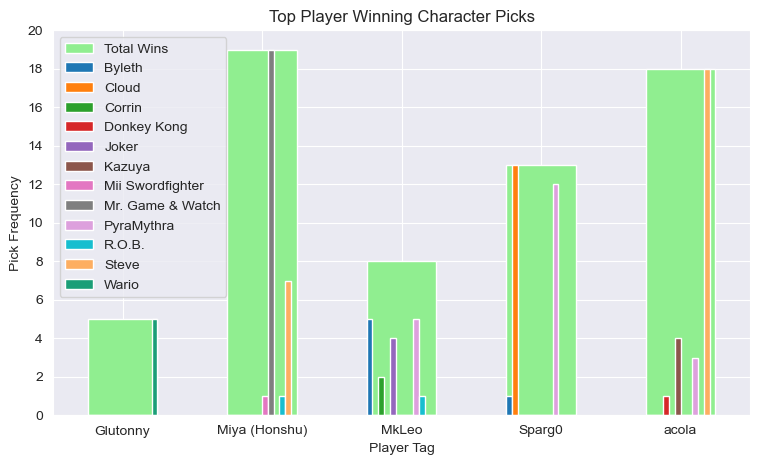

In [317]:
#use dummies to encode the characters played for the top 5 players. 
top_plyr_winning_chars   =  (pd.get_dummies(df.explode('characters_played')
                                             .query('player.isin(["Miya (Honshu)","acola","Sparg0","MkLeo","Glutonny"]) & placing_groups=="1st"'), 
                                                          prefix='', columns=['characters_played'])
                                             .drop(columns=['placing','nationality','tournament_country','tournament_name','player_region',
                                                             'tournament_region','start_Date','end_Date','placing_groups','is_supermajor'])
                                             .rename(columns=lambda c: c.replace('_','')))

fig, ax = plt.subplots(figsize=(9,5),sharex=True)
#Make a dataframe with the players in the index and the number of wins they have
top_plyr_wins_count  = (
                            df.query('player.isin(["Miya (Honshu)","acola","Sparg0","MkLeo","Glutonny"]) & placing=="1st"')
                              .groupby(['player'], observed=True)['placing']
                              .agg(['count'])       
                       )
#list of colours to be used in the plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', 
          '#7f7f7f', 'plum', '#17becf', '#fdae61', '#1b9e77']

#plot the total nuber of wins
(
    top_plyr_wins_count.plot.bar(ax=ax,color='lightgreen',label='Total Wins')
)

#Groups the encoded dataframe above by player selecting the character columns. Reindexes to match the index of the wins_count dataframe directly above.
(
    top_plyr_winning_chars.groupby('player',observed=True)[top_plyr_winning_chars.columns[1:]]
                          .sum().reindex(index=top_plyr_wins_count.index).plot.bar(ax=ax, rot=0, color = colors[:len(top_plyr_winning_chars.columns)])
)

#sets graph parameters.
ax.set_title('Top Player Winning Character Picks')
ax.set_ylabel('Pick Frequency')
ax.set_xlabel('Player Tag')
ax.set_yticks(range(0,21,2))
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'Total Wins'  # Ensure the label for the first plot is correct
ax.legend(handles, labels, loc='best')


Gluttony, Miya , Sparg0 and acola have always played at least one of the same character in every tournament they have won. 
We've already seen how the number of top 8 placements has a positive correlation with the popoularity of a character. 


These players are the most successful overall and with their main characters' of choice.

- Sparg0 has been the only player to place 1st place using Cloud.
- A majority of wins associated with Steve come from acola. 
- Miya is the only player to have won a major/supermajor as Mr. Game & Watch.
- Gluttony has one 5/6 tournaments where a wario player has been successful.
- MkLeo over the past 2.5 years has perofrmed well with a variety of characters. 5/6 - Byleth, 2/4 Corrin, 4/6 Joker, 1/6 R.O.B. 

# Points system:
We can implement a simple points system to score both players and tournaments. These scores also enable a way to rank/tier tournaments and in turn assign more fitting points for players. 


#### Tournament Scores
Tournaments will be scored based on the number of top level players in attendance. We can do this by initially assigning scores  per tournament to players based on their placing group of 1st, Top3 or Top8, with more points being assigned the higher the placing group.  These 'placing points' will then be summed for every individual player. The score of a tournament will be the sum the players' 'placing points' for that tournamnt.The tournaments' scores are then binned into 9 equal-width groups, informing their ranks/tiers : 'D', 'C', 'B', 'B+', 'A', 'A+', 'S', 'S+', 'P' in ascending order. These tiers will have a "tier scalar" value attached to them in another column. 

#### Player Scores
A true score named "Player Points" will also be given to each player based on their placing group for _all_ placing groups. These points will have standard values for each placing_group. These values will be multiplied by the tier_scalar increasing their value according to the tier of tournament that was played. Essentially what this means is that a player who wins a D tier tournament will recieve fewer points than a player who wins a P tier tournament. 



#### Why do this?

- We can use this to identify the best players based on a comprehensive score informed both by results and the level of competition.
- We can also use this to group characters by the players who have the greatest score when playing them enabling us to find the best players for specific characters.




In [318]:
#Creates a series with points corresponding to individual placing groups and adding it to the main dataframe.

place_group = df.placing_groups 


placing_points = pd.Series(np.select([place_group.isin(['1st']), place_group.isin(['Top3']), place_group.isin(['Top8'])],
         [4,2,1], 0),name='placing_points') 

df = pd.concat([df,placing_points],axis=1)

In [319]:
#Creates new columns that rank tournaments and players based on how many points they have.

df = (df
         
      #player_points is the sum of all placing points a player scored within the dataset
         .assign(player_points = (df.groupby('player')
                                    .placing_points
                                    .transform('sum')))
         
      #tournament_points is the sum of all player points for a particular tournament
         .assign(tournament_points = lambda g: (g.groupby('tournament_name')['player_points']
                                      .transform('sum')))
         
      #tournament_tier is a rank of a tournament based on the binned values of tournament_points.
         .assign(tournament_tier = lambda g: pd.cut(g.tournament_points,9,
                                          labels= ['D', 'C', 'B', 'B+', 'A', 'A+', 'S', 'S+', 'P']))
          
      #tier_scalar is an integer corresponding to the rank of a tourament that will be multiplied with a players points.
         .assign(tier_scalar = lambda g: g.tournament_tier
                                          .replace({'D':1, 'C':1.25, 'B':1.5, 'B+':1.75, 'A':2, 'A+':2.25, 'S':2.5, 'S+':2.75, 'P':3}).astype('uint8'),
                 
                 #points awarded to players based on their placing in a tournament. Will be scaled based on tournament tier.
                 points = lambda g: g.placing_groups
                                     .replace({'1st':20,'Top3':12,'Top8':8,'Top16':4,'Top32':2,'Top64':0}).astype('int8'))
                
              #points_scaled : points multiplied by tier scalar corresponding to tournament tier.
         .assign(points_scaled = lambda g: g.tier_scalar *  g.points)
         .drop(columns=['placing_points','tournament_points','tier_scalar'])
     )

C:\Users\User\AppData\Local\Temp\ipykernel_6444\711403295.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .assign(player_points = (df.groupby('player')
C:\Users\User\AppData\Local\Temp\ipykernel_6444\711403295.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .assign(tournament_points = lambda g: (g.groupby('tournament_name')['player_points']


#### REMAKING THE DATAFRAMES FOR EACH PLACING GROUP

In [320]:

# Creates 3 lists containing the placing for top 8, top16 and top32 tournament placings respectively
top8_placings = ['1st','2nd','3rd','4th','5th','7th']
top16_placings = top8_placings + ['9th','10th','13th']
top32_placings = top16_placings + ['17th','23rd','25th','29th'] 

#instantiate dataframes containing just players in the top 8, 16 and 32 of tournaments respectively.
df_top8 = df[df['placing'].isin(top8_placings)]
df_top16 = df[df['placing'].isin(top16_placings)]
df_top32 = df[df['placing'].isin(top32_placings)]

#The same as above but for supermajor tournaments. 
df_supermajors = df[df['tournament_name'].isin(supermajor_tournaments)] #All data excluxively for supermajor tournaments.
df_supermajors_top8 = df_supermajors[df_supermajors['placing'].isin(top8_placings)]
df_supermajors_top16 = df_supermajors[df_supermajors['placing'].isin(top16_placings)]
df_supermajors_top32 = df_supermajors[df_supermajors['placing'].isin(top32_placings)]

## Which players have dominated the competitive scene since 2022? Has there been any shift?
The shift in players' tournament placing consistency is an important question to answer. That of which players have dominated and contunie to dominate, which players no longer win consitently or at all? Which players have show improvement over time. 


In [321]:
#creates a list of the top 5 percent of players with the greatest number of points. 
def plyr_top_pct(df_):
       return   (
                df_
                .query('points_scaled!=0') #filters out players who have a point score of 0
                .groupby('player',observed=True)
                .points_scaled
                .sum()
                .pipe(lambda x : x[x>=x.quantile(0.90)])
                .index
                .tolist()
                )
    
#gets the top 10 percent players from data of only top 8 toournament data
x = plyr_top_pct(df_top8)
x.sort()

In [322]:
#Function that plots the number of 1st, top3 and top8 placements for the top 5 percent players
def top8_performance_metrics(df_, num):
    
    

    #creates a dataframe object that has the sum of top3,top8 and 1st place tournament placings for the players in list 'x'
    data = ((pd.get_dummies(df_.query('player.isin(@x)')[['player','placing_groups']],
                                       prefix=[''], 
                                       columns=['placing_groups']))
                        .drop(columns=['_Top16','_Top32','_Top64'])
                        .rename(columns=lambda c: c.replace('_',''))
                        .groupby('player', observed=True)[['1st', 'Top3','Top8']]
                        .agg({'1st':'sum', 'Top3':'sum', 'Top8':'sum'}))
    
    data_tournament_name = (df_.query('player.isin(@x)')[['player', 'tournament_name']]
                            .rename(columns={'tournament_name': 'Tourneys Played'})
                            .groupby('player', observed=True)['Tourneys Played']
                            .count())
    
    ytick_max = data_tournament_name.max()

    #plot number of tournaments played
    data_tournament_name.plot.bar(ax=ax[num], color='firebrick', label='Tournaments Played',position=0)
    
    #plot 'data' in bar plot form
    data.plot.bar(stacked=True, rot=75, ax=ax[num],position=0.3)
    ax[num].set_ylabel('No. Placements')
    ax[num].set_xlabel('Player')
    ax[num].set_yticks(range(0,ytick_max+1,2))
    ax[num].legend(loc='best')


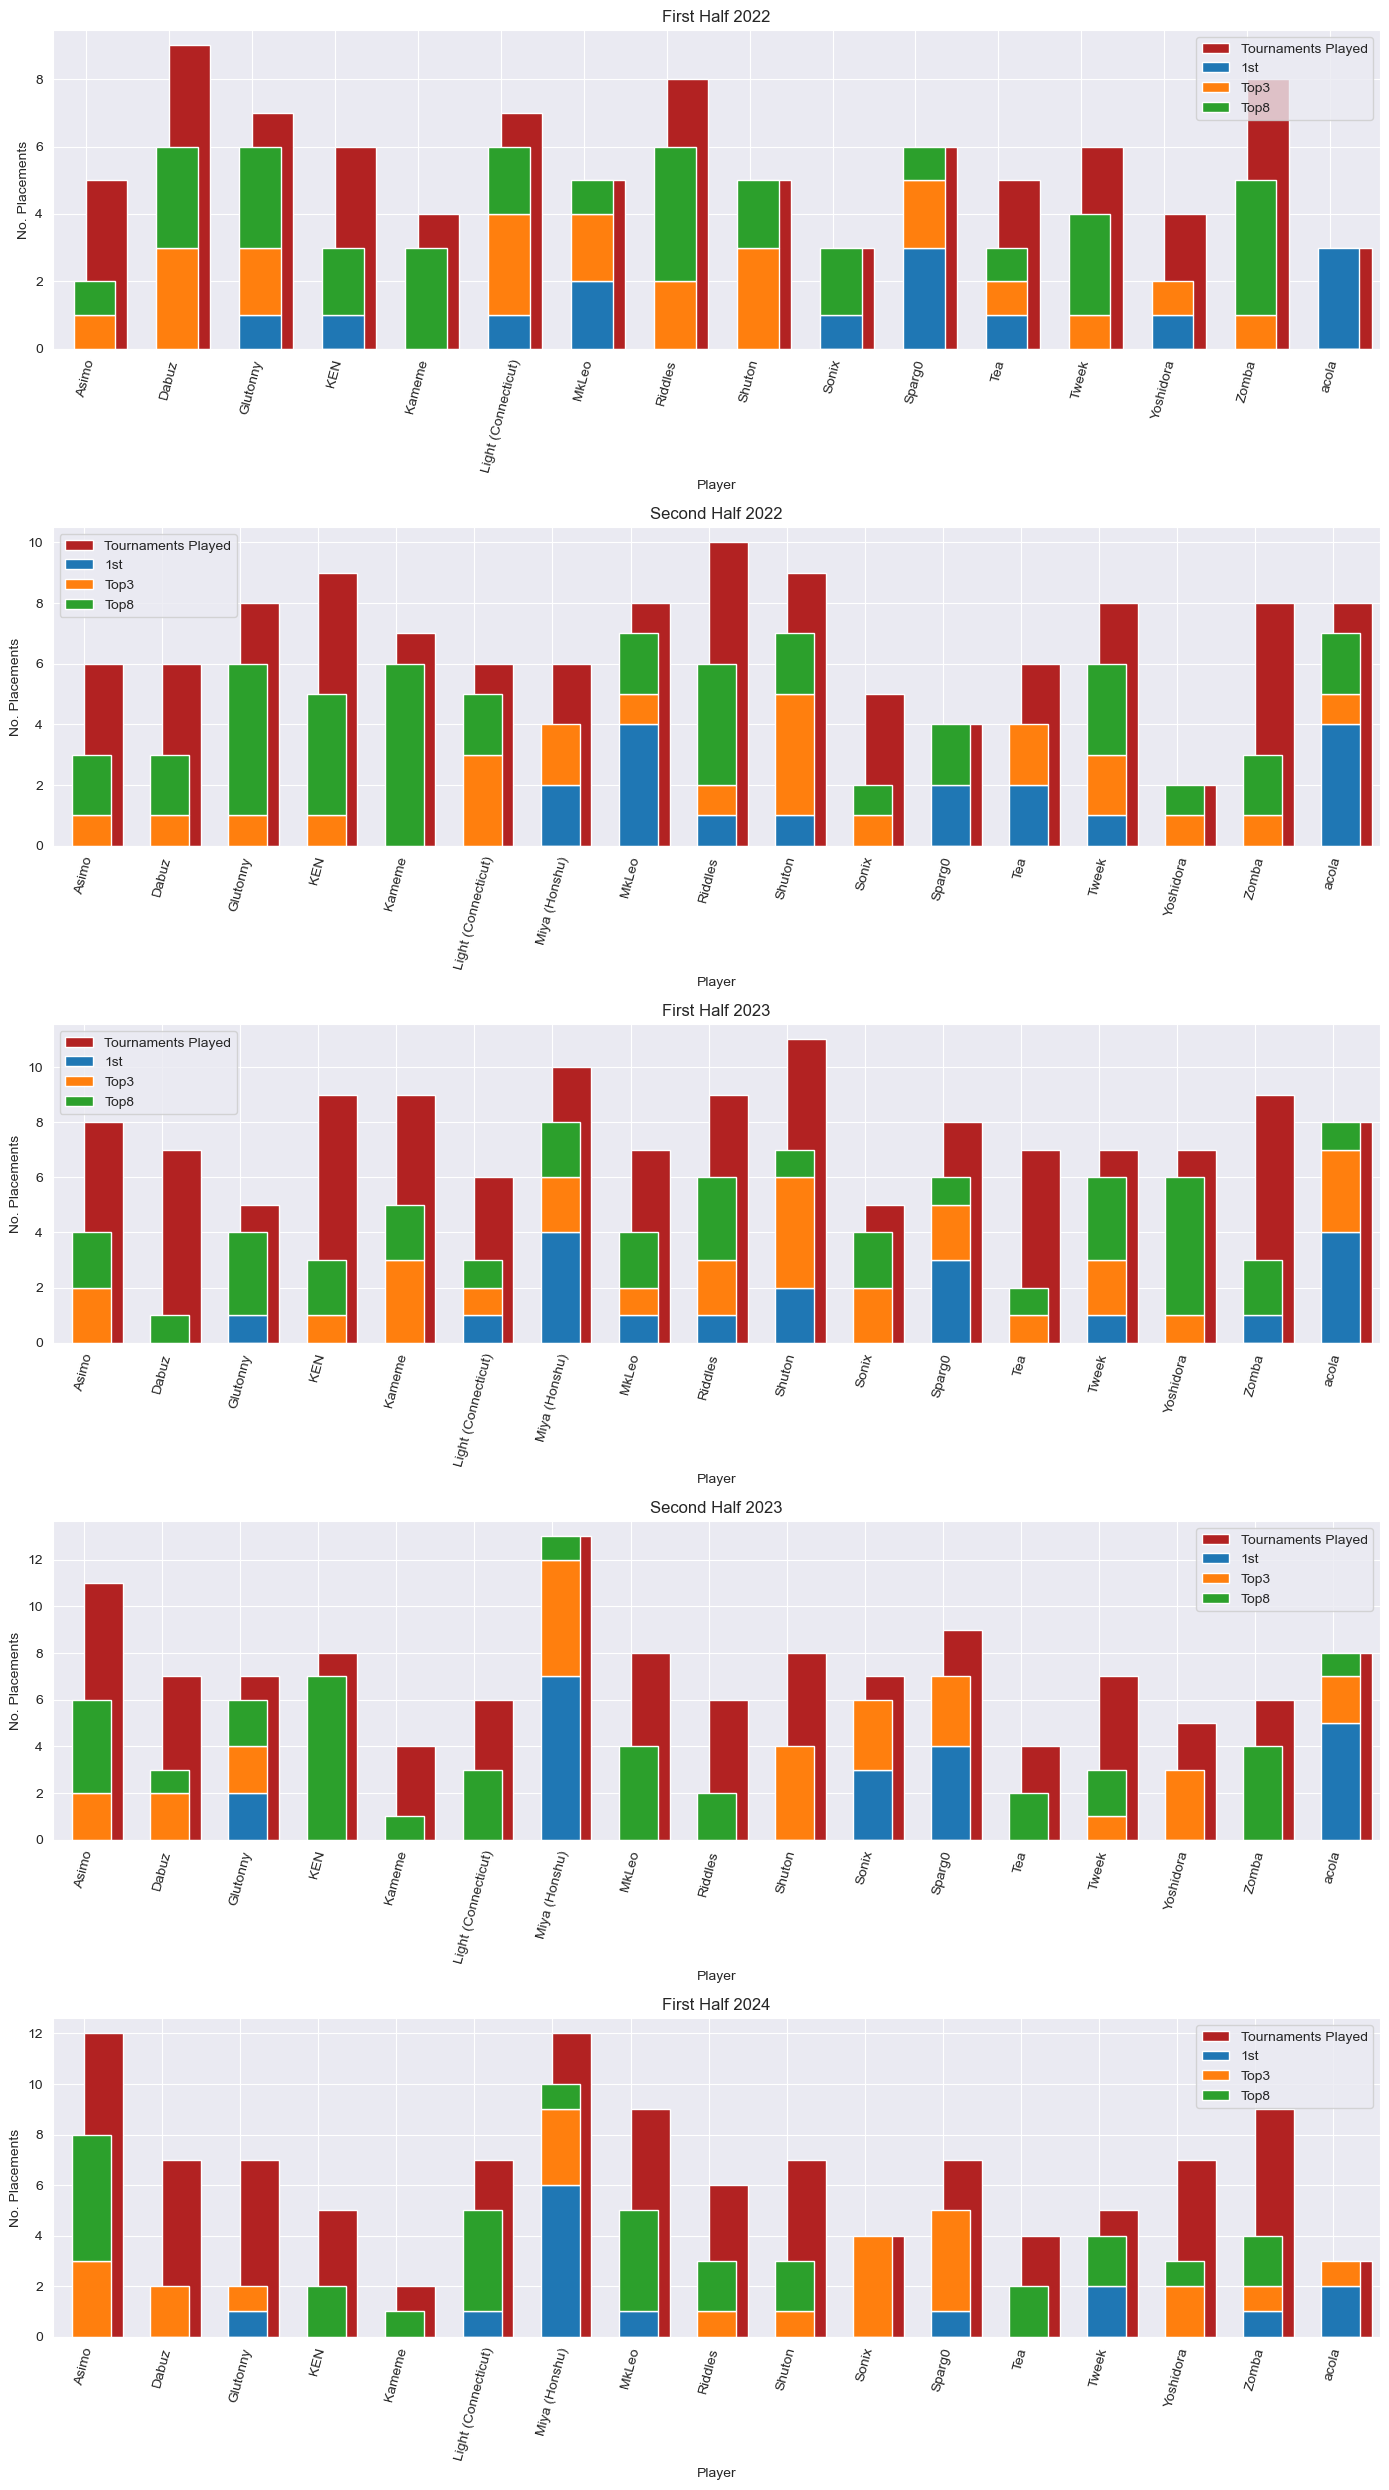

In [359]:

#CREATES dataframe objects containing information from the main dataframe in six month intervals
df_top8_1st_half_2022 = df.set_index('start_Date').sort_index().loc['2022-1':'2022-6']

df_top8_2nd_half_2022 = df.set_index('start_Date').sort_index().loc['2022-7':'2022-12']

df_top8_1st_half_2023 = df.set_index('start_Date').sort_index().loc['2023-1':'2023-6']

df_top8_2nd_half_2023 = df.set_index('start_Date').sort_index().loc['2023-7':'2023-12']

df_top8_1st_half_2024 = df.set_index('start_Date').sort_index().loc['2024-1':'2024-7']

#plots bar graphs of each dataframe object using function defined above
fig,ax = plt.subplots((5), figsize=(14,25))
top8_performance_metrics(df_top8_1st_half_2022,0)

top8_performance_metrics(df_top8_2nd_half_2022,1)

top8_performance_metrics(df_top8_1st_half_2023,2)

top8_performance_metrics(df_top8_2nd_half_2023,3)

top8_performance_metrics(df_top8_1st_half_2024,4)


ax[0].set_title('First Half 2022')
ax[1].set_title('Second Half 2022')
ax[2].set_title('First Half 2023')
ax[3].set_title('Second Half 2023')
ax[4].set_title('First Half 2024')

plt.tight_layout()


## Top Player Consistency

The above graphs display the results of the top 5th percentile quality players in six month intervals. 

Their results in the top8 are compared with the total number of tournaments they have entered. The rankings are informed by th points system so there are instances where some players such as "Quidd" who have won a tournament are excluded because they did not participate in many tournaments or high tier tournaments. 

From the data we can see a few players whose results have dropped over time.
- MKLeo's win rate and rate of progressing into the top 8 has dropped.
- Miya and acola are the clear dominant players having the most consistent number of wins in each interval. With non wins almost always being top 3 placements. 
- Sparg0 also shows consistent improvement.
- Sonix has improved overt time often placing in top3 if not first. 
- Kameme and Ken are interesting. They have no tournament wins but tey consistently attend high tier tournaments and manage to to place well in a majority of them. 

### Player Result Showcase: MkLeo 
Let's look at how MkLeo's results have changed over time.

In [344]:
# df containing all MkLeo's placing_groups
MkLeo_results = (
                df.query('player == "MkLeo"').set_index('start_Date')['placing_groups']
                )
# create a mapping for the placing groups giving them numerical values.
numerical_placing_map = {
    '1st':6,
    'Top3':5,
    'Top8':4,
    'Top16':3,
    'Top32':2,
    'Top64':1
}
#maps the results to the values above
MkLeo_results = MkLeo_results.map(numerical_placing_map)

([<matplotlib.axis.YTick at 0x26b993a1890>,
 [Text(0, 6, '1st'),
  Text(0, 5, 'Top3'),
  Text(0, 4, 'Top8'),
  Text(0, 3, 'Top16'),
  Text(0, 2, 'Top32'),
  Text(0, 1, 'Top64')])

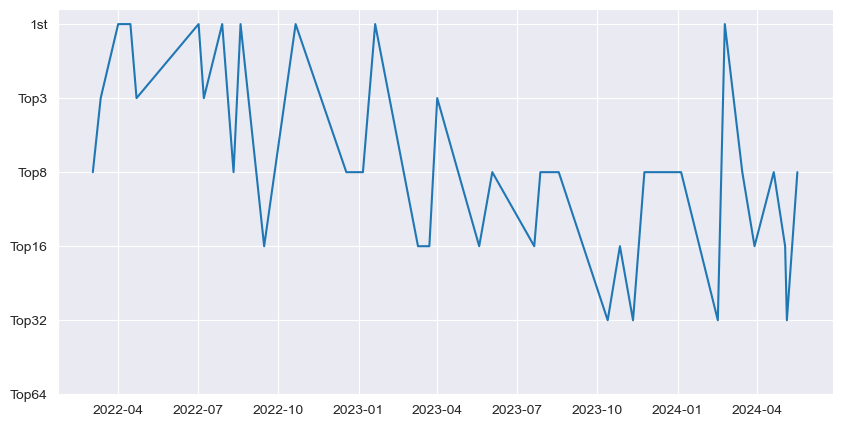

In [356]:
plt.figure(figsize=(10,5))
#plot the dataframe
plt.plot(MkLeo_results.index, MkLeo_results)

#replace the y tick values with the values of the placing_groups#
plt.yticks(ticks = list(numerical_placing_map.values()), labels=list(numerical_placing_map.keys()))

### For a given character, who are their best players. 

Players seeking to improve or learn more about characters can observe gameplay from top players with specific characters.

In [326]:
#create list of chars whose number of unique tournament appearances is greater than the median value of unique appearances.  

top_char_list = (df.explode('characters_played')
      .groupby(['characters_played'], observed=True)['tournament_name'].nunique()
      .pipe(lambda x :x[x>=x.quantile(0.50)])
      .sort_values( ascending = False)
      .index
      .tolist()
)

In [327]:
#a list of all characters
all_chars =pd.unique(df.explode('characters_played').characters_played).tolist()

In [328]:
#instantiate a dataframe with 2 columns: character and players
best_plyr_char = pd.DataFrame(columns=['Character','Players'])

#For each character in top_char_list generates a list players with the greatest number of points
for i in range(len(all_chars)):
    char = all_chars[i]
    best_players = (df
                       .explode('characters_played') 
                       .query('characters_played == @char') #filters dataframe for specific characters
                       .groupby(['player'], observed=True)
                       .agg({'points_scaled':'sum'}) #sums the players points_scaled values
                       .sort_values(by='points_scaled',ascending=False) #sort values in ascending order
                       .iloc[:3] #index the first three rows
                       .index
                       .tolist() #generate a list of the index values (player names)
                  )
    
    #creates a new row with index i with current character value in the loop and the highest scoring corresponding players.
    best_plyr_char.loc[i]=[all_chars[i], best_players] 

In [329]:
best_plyr_char

,Character,Players
0,Pokémon Trainer,"[Noi, Quidd, Atelier]"
1,Roy,"[Kola, Goblin, alice]"
2,Cloud,"[Sparg0, Kola, YOC]"
3,Peach,"[MuteAce, Ling, Eik]"
4,Rosalina & Luma,"[Dabuz, yuzu, YamaD]"
...,...,...
81,King K. Rool,"[Huto, Yaura, Lukewarm]"
82,Zelda,"[Yn, Maipan, Naskino]"
83,Banjo & Kazooie,"[Toriguri, WaDi, ZAKI]"
84,Ganondorf,"[Higachan, Komegura, Gungnir]"


These players are among the best if not the best that showcase the capabilities of specific characters. Players looking to learn can watch videos of these players' games to gain some knowledge for their own competitive play.